In [1]:
!ls

CeLEry-data-agumentation.ipynb	Mouse_sc_analysis.py
CellLocation4.py		Mouse_sc_analysis-results.py
CellLocation4_result2.py	Mouse_sc_pre.py
CellLocation4_result.py		Mouse_spotOTsc.ipynb
Mouse_CeLEry.ipynb		Mouse_Tangram.ipynb
Mouse_CeLEry_oldcode.ipynb	novosparc.ipynb
Mouse_novosparc.ipynb		Tangram4.py
Mouse_sc_analysis.ipynb		Untitled-Copy2.ipynb


In [1]:
import sys

## 1. Data Preperation

### 1.1 Preperation
Load packages:

In [2]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
from sklearn.cluster import KMeans

from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import pickle

#Read original data and save it to h5ad
from scanpy import read_10x_h5



In [3]:
import cv2 as cv
from skimage import io, color

In [4]:
%cd /lustre03/project/6075067/calcium/2021/CeLEry

/lustre03/project/6075067/calcium/2021/CeLEry


In [5]:
import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel
cel.__version__

'1.1.2'

### 1.2 Load Data

In [7]:
from data.Mouse2D.MP1_SVG import d_g


### Load MouseBarin Data Section 1: Regarded as Spatial Transcriptomic Data
dataSection1full = sc.read("data/MouseBrain/MP1_sudo.h5ad")
genename = dataSection1full.var['genename']


# Get the gene list from the pre-screening
genelistlist = [d_g[i] for i in  range(len(d_g))]  # transform dictionary to a list of lists
genelist = sum(genelistlist, [])  # merge the list of lists
genelistuni = list( dict.fromkeys(genelist) )   # remove duplicates

genelistindex = [genename[genename == i].index[0] for i in genelistuni if  len(genename[genename == i])>0]


In [8]:
#Read in hitology image
ImageSec1=io.imread("data/MouseBrain/V1_Mouse_Brain_Sagittal_Posterior_image.tif")
ImageSec1sub = ImageSec1[3000:7000,6200:10500,:]
# spc.printimage (ImageSec1sub, "../output/CeLEry/imageselect")

In [9]:
imgray = cv.cvtColor(ImageSec1sub, cv.COLOR_BGR2GRAY)
imgray2 = imgray.copy()
imgray2[imgray2<160] = 0
imgray2[imgray2>160] = 255

## Take the subset of dataSection1
xcords = dataSection1full.obs["x"].to_numpy()
ycords = dataSection1full.obs["y"].to_numpy()

Section1Sub = dataSection1full[(xcords>=3000) & (xcords<7000) & (ycords>=6200) & (ycords<10500), genelistindex]
Section1Sub.obs = Section1Sub.obs/50
Section1Sub.obs = Section1Sub.obs.astype(int)
Section1Sub.obs["inner"] = 0

## Quality Control

for i in range(Section1Sub.obs.shape[0]):
    xi = Section1Sub.obs["x"][i]
    yi = Section1Sub.obs["y"][i]
    subarea = np.mean(imgray2[(xi*50-3000):(xi*50+50-3000), (yi*50-6200):(yi*50+50-6200)])
    if subarea<140 or xi*50>6000:
         Section1Sub.obs["inner"].iloc[i] = 1
    if yi*50>10200 or xi*50<1000:
         Section1Sub.obs["inner"].iloc[i] = 0

Section1Sub = Section1Sub[Section1Sub.obs["inner"] == 1]

In [10]:
len(genelistindex)

358

In [11]:
Section1Sub.obs

,x,y,inner
2408,61,124,1
2432,61,164,1
2433,61,165,1
2434,61,166,1
2435,61,167,1
...,...,...,...
17025,139,200,1
17026,139,201,1
17027,139,202,1
17028,139,203,1


In [12]:
## Calculating z-score
cel.get_zscore(Section1Sub)

index10 = np.load("output/CeLEry/index10.npy")
index30 = np.load("output/CeLEry/index30.npy")
index50 = np.load("output/CeLEry/index50.npy")

# split the data into training and testing data

# 10% hold off
Section1train10 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index10)),]
Section1test10 = Section1Sub[list(set(index10)),]

# 30% hold off
Section1train30 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index30)),]
Section1test30 = Section1Sub[list(set(index30)),]

# 50% hold off
Section1train50 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index50)),]
Section1test50 = Section1Sub[list(set(index50)),]

In [ ]:
cel.Fit_cord (Section1train10, location_data = Section1train10.obs[["x","y"]], path = "output/CeLEry/2022Nov", filename = "HighReso_10", number_error_try = 50, batch_size = 16, num_workers = 0, initial_learning_rate = 0.001, hidden_dims = [100,64,32])

In [15]:
cel.Fit_cord (Section1train30, location_data = Section1train30.obs[["x","y"]], path = "output/CeLEry/2022Nov", filename = "HighReso_30", number_error_try = 50, batch_size = 8, num_workers = 0, initial_learning_rate = 0.001, hidden_dims = [100,64,32])

100%|██████████| 510/510 [00:00<00:00, 770.45it/s]


Epoch:1, Loss:6.8412


100%|██████████| 510/510 [00:00<00:00, 751.67it/s]


Epoch:2, Loss:1.3004


100%|██████████| 510/510 [00:00<00:00, 780.63it/s]


Epoch:3, Loss:0.9228


100%|██████████| 510/510 [00:00<00:00, 787.10it/s]


Epoch:4, Loss:0.7668


100%|██████████| 510/510 [00:00<00:00, 785.82it/s]


Epoch:5, Loss:0.6666


100%|██████████| 510/510 [00:00<00:00, 786.45it/s]


Epoch:6, Loss:0.6721


100%|██████████| 510/510 [00:00<00:00, 786.29it/s]


Epoch:7, Loss:0.7047


100%|██████████| 510/510 [00:00<00:00, 786.09it/s]


Epoch:8, Loss:0.5801


100%|██████████| 510/510 [00:00<00:00, 784.06it/s]


Epoch:9, Loss:0.5692


100%|██████████| 510/510 [00:00<00:00, 784.88it/s]


Epoch:10, Loss:0.6443


100%|██████████| 510/510 [00:00<00:00, 786.46it/s]


Epoch:11, Loss:0.6735


100%|██████████| 510/510 [00:00<00:00, 785.08it/s]


Epoch:12, Loss:0.4805


100%|██████████| 510/510 [00:00<00:00, 776.43it/s]


Epoch:13, Loss:0.5545


100%|██████████| 510/510 [00:00<00:00, 781.68it/s]


Epoch:14, Loss:0.5542


100%|██████████| 510/510 [00:00<00:00, 770.56it/s]


Epoch:15, Loss:0.5631


100%|██████████| 510/510 [00:00<00:00, 771.86it/s]


Epoch:16, Loss:0.5025


100%|██████████| 510/510 [00:00<00:00, 763.31it/s]


Epoch:17, Loss:0.4883


100%|██████████| 510/510 [00:00<00:00, 764.47it/s]


Epoch:18, Loss:0.4757


100%|██████████| 510/510 [00:00<00:00, 763.37it/s]


Epoch:19, Loss:0.5718


100%|██████████| 510/510 [00:00<00:00, 764.93it/s]


Epoch:20, Loss:0.5049


100%|██████████| 510/510 [00:00<00:00, 773.02it/s]


Epoch:21, Loss:0.4463


100%|██████████| 510/510 [00:00<00:00, 773.04it/s]


Epoch:22, Loss:0.4528


100%|██████████| 510/510 [00:00<00:00, 778.01it/s]


Epoch:23, Loss:0.4822


100%|██████████| 510/510 [00:00<00:00, 778.05it/s]


Epoch:24, Loss:0.4983


100%|██████████| 510/510 [00:00<00:00, 741.92it/s]


Epoch:25, Loss:0.4058


100%|██████████| 510/510 [00:00<00:00, 777.40it/s]


Epoch:26, Loss:0.4123


100%|██████████| 510/510 [00:00<00:00, 778.65it/s]


Epoch:27, Loss:0.5246


100%|██████████| 510/510 [00:00<00:00, 782.06it/s]


Epoch:28, Loss:0.5223


100%|██████████| 510/510 [00:00<00:00, 779.34it/s]


Epoch:29, Loss:0.4019


100%|██████████| 510/510 [00:00<00:00, 770.54it/s]


Epoch:30, Loss:0.4167


100%|██████████| 510/510 [00:00<00:00, 774.58it/s]


Epoch:31, Loss:0.3991


100%|██████████| 510/510 [00:00<00:00, 759.14it/s]


Epoch:32, Loss:0.3940


100%|██████████| 510/510 [00:00<00:00, 750.74it/s]


Epoch:33, Loss:0.4477


100%|██████████| 510/510 [00:00<00:00, 734.64it/s]


Epoch:34, Loss:0.3993


100%|██████████| 510/510 [00:00<00:00, 742.98it/s]


Epoch:35, Loss:0.4280


100%|██████████| 510/510 [00:00<00:00, 742.29it/s]


Epoch:36, Loss:0.4433


100%|██████████| 510/510 [00:00<00:00, 747.16it/s]


Epoch:37, Loss:0.3905


100%|██████████| 510/510 [00:00<00:00, 766.81it/s]


Epoch:38, Loss:0.3850


100%|██████████| 510/510 [00:00<00:00, 769.15it/s]


Epoch:39, Loss:0.3844


100%|██████████| 510/510 [00:00<00:00, 759.90it/s]


Epoch:40, Loss:0.5057


100%|██████████| 510/510 [00:00<00:00, 749.96it/s]


Epoch:41, Loss:0.3644


100%|██████████| 510/510 [00:00<00:00, 741.53it/s]


Epoch:42, Loss:0.3978


100%|██████████| 510/510 [00:00<00:00, 746.78it/s]


Epoch:43, Loss:0.3473


100%|██████████| 510/510 [00:00<00:00, 754.16it/s]


Epoch:44, Loss:0.3786


100%|██████████| 510/510 [00:00<00:00, 745.21it/s]


Epoch:45, Loss:0.5263


100%|██████████| 510/510 [00:00<00:00, 747.05it/s]


Epoch:46, Loss:0.3350


100%|██████████| 510/510 [00:00<00:00, 705.46it/s]


Epoch:47, Loss:0.3425


100%|██████████| 510/510 [00:00<00:00, 743.04it/s]


Epoch:48, Loss:0.3752


100%|██████████| 510/510 [00:00<00:00, 753.68it/s]


Epoch:49, Loss:0.3518


100%|██████████| 510/510 [00:00<00:00, 752.79it/s]


Epoch:50, Loss:0.4134


100%|██████████| 510/510 [00:00<00:00, 744.01it/s]


Epoch:51, Loss:0.3686


100%|██████████| 510/510 [00:00<00:00, 749.35it/s]


Epoch:52, Loss:0.3576


100%|██████████| 510/510 [00:00<00:00, 749.49it/s]


Epoch:53, Loss:0.3591


100%|██████████| 510/510 [00:00<00:00, 748.63it/s]


Epoch:54, Loss:0.3814


100%|██████████| 510/510 [00:00<00:00, 738.02it/s]


Epoch:55, Loss:0.4146


100%|██████████| 510/510 [00:00<00:00, 729.15it/s]


Epoch:56, Loss:0.3486


100%|██████████| 510/510 [00:00<00:00, 722.92it/s]


Epoch:57, Loss:0.4008


100%|██████████| 510/510 [00:00<00:00, 726.82it/s]


Epoch:58, Loss:0.3447


100%|██████████| 510/510 [00:00<00:00, 726.00it/s]


Epoch:59, Loss:0.3416


100%|██████████| 510/510 [00:00<00:00, 729.21it/s]


Epoch:60, Loss:0.3631


100%|██████████| 510/510 [00:00<00:00, 728.26it/s]


Epoch:61, Loss:0.3374


100%|██████████| 510/510 [00:00<00:00, 722.47it/s]


Epoch:62, Loss:0.3658


100%|██████████| 510/510 [00:00<00:00, 732.92it/s]


Epoch:63, Loss:0.3447


100%|██████████| 510/510 [00:00<00:00, 741.73it/s]


Epoch:64, Loss:0.3763


100%|██████████| 510/510 [00:00<00:00, 735.29it/s]


Epoch:65, Loss:0.3649


100%|██████████| 510/510 [00:00<00:00, 732.63it/s]


Epoch:66, Loss:0.3394


100%|██████████| 510/510 [00:00<00:00, 727.46it/s]


Epoch:67, Loss:0.3459


100%|██████████| 510/510 [00:00<00:00, 716.46it/s]


Epoch:68, Loss:0.3638


100%|██████████| 510/510 [00:00<00:00, 685.64it/s]


Epoch:69, Loss:0.3524


100%|██████████| 510/510 [00:00<00:00, 719.10it/s]


Epoch:70, Loss:0.8860
New learning rate:0.0005


100%|██████████| 510/510 [00:00<00:00, 712.20it/s]


Epoch:71, Loss:0.3018


100%|██████████| 510/510 [00:00<00:00, 696.01it/s]


Epoch:72, Loss:0.2492


100%|██████████| 510/510 [00:00<00:00, 675.54it/s]


Epoch:73, Loss:0.2404


100%|██████████| 510/510 [00:00<00:00, 692.12it/s]


Epoch:74, Loss:0.2314


100%|██████████| 510/510 [00:00<00:00, 681.17it/s]


Epoch:75, Loss:0.2288


100%|██████████| 510/510 [00:00<00:00, 708.15it/s]


Epoch:76, Loss:0.2342


100%|██████████| 510/510 [00:00<00:00, 710.13it/s]


Epoch:77, Loss:0.2309


100%|██████████| 510/510 [00:00<00:00, 720.46it/s]


Epoch:78, Loss:0.2292


100%|██████████| 510/510 [00:00<00:00, 737.68it/s]


Epoch:79, Loss:0.2325


100%|██████████| 510/510 [00:00<00:00, 735.93it/s]


Epoch:80, Loss:0.2329


100%|██████████| 510/510 [00:00<00:00, 739.07it/s]


Epoch:81, Loss:0.2184


100%|██████████| 510/510 [00:00<00:00, 731.22it/s]


Epoch:82, Loss:0.2299


100%|██████████| 510/510 [00:00<00:00, 731.96it/s]


Epoch:83, Loss:0.2216


100%|██████████| 510/510 [00:00<00:00, 729.64it/s]


Epoch:84, Loss:0.2283


100%|██████████| 510/510 [00:00<00:00, 715.69it/s]


Epoch:85, Loss:0.2159


100%|██████████| 510/510 [00:00<00:00, 711.66it/s]


Epoch:86, Loss:0.2224


100%|██████████| 510/510 [00:00<00:00, 715.61it/s]


Epoch:87, Loss:0.2338


100%|██████████| 510/510 [00:00<00:00, 716.43it/s]


Epoch:88, Loss:0.2196


100%|██████████| 510/510 [00:00<00:00, 725.41it/s]


Epoch:89, Loss:0.2199


100%|██████████| 510/510 [00:00<00:00, 694.23it/s]


Epoch:90, Loss:0.2248


100%|██████████| 510/510 [00:00<00:00, 741.56it/s]


Epoch:91, Loss:0.2279


100%|██████████| 510/510 [00:00<00:00, 737.77it/s]


Epoch:92, Loss:0.2125


100%|██████████| 510/510 [00:00<00:00, 726.46it/s]


Epoch:93, Loss:0.2152


100%|██████████| 510/510 [00:00<00:00, 716.15it/s]


Epoch:94, Loss:0.2221


100%|██████████| 510/510 [00:00<00:00, 717.32it/s]


Epoch:95, Loss:0.2298


100%|██████████| 510/510 [00:00<00:00, 716.59it/s]


Epoch:96, Loss:0.2150


100%|██████████| 510/510 [00:00<00:00, 719.34it/s]


Epoch:97, Loss:0.2186


100%|██████████| 510/510 [00:00<00:00, 710.07it/s]


Epoch:98, Loss:0.2154


100%|██████████| 510/510 [00:01<00:00, 296.75it/s]


Epoch:99, Loss:0.2272


100%|██████████| 510/510 [00:00<00:00, 714.06it/s]


Epoch:100, Loss:0.2157


100%|██████████| 510/510 [00:00<00:00, 716.45it/s]


Epoch:101, Loss:0.2157


100%|██████████| 510/510 [00:00<00:00, 728.38it/s]


Epoch:102, Loss:0.2150


100%|██████████| 510/510 [00:00<00:00, 736.39it/s]


Epoch:103, Loss:0.2151


100%|██████████| 510/510 [00:00<00:00, 735.42it/s]


Epoch:104, Loss:0.2197


100%|██████████| 510/510 [00:00<00:00, 727.15it/s]


Epoch:105, Loss:0.2163


100%|██████████| 510/510 [00:00<00:00, 690.69it/s]


Epoch:106, Loss:0.2278


100%|██████████| 510/510 [00:00<00:00, 676.76it/s]


Epoch:107, Loss:0.2007


100%|██████████| 510/510 [00:00<00:00, 690.12it/s]


Epoch:108, Loss:0.2216


100%|██████████| 510/510 [00:00<00:00, 688.17it/s]


Epoch:109, Loss:0.2254


100%|██████████| 510/510 [00:00<00:00, 717.78it/s]


Epoch:110, Loss:0.2149


100%|██████████| 510/510 [00:00<00:00, 720.30it/s]


Epoch:111, Loss:0.2132


100%|██████████| 510/510 [00:00<00:00, 719.47it/s]


Epoch:112, Loss:0.2164


100%|██████████| 510/510 [00:00<00:00, 699.21it/s]


Epoch:113, Loss:0.2096


100%|██████████| 510/510 [00:00<00:00, 724.52it/s]


Epoch:114, Loss:0.2155


100%|██████████| 510/510 [00:00<00:00, 724.62it/s]


Epoch:115, Loss:0.2162


100%|██████████| 510/510 [00:00<00:00, 725.68it/s]


Epoch:116, Loss:0.2135


100%|██████████| 510/510 [00:00<00:00, 726.17it/s]


Epoch:117, Loss:0.2062


100%|██████████| 510/510 [00:00<00:00, 721.39it/s]


Epoch:118, Loss:0.2209


100%|██████████| 510/510 [00:00<00:00, 715.74it/s]


Epoch:119, Loss:0.2105


100%|██████████| 510/510 [00:00<00:00, 713.16it/s]


Epoch:120, Loss:0.2100


100%|██████████| 510/510 [00:00<00:00, 716.05it/s]


Epoch:121, Loss:0.2180


100%|██████████| 510/510 [00:00<00:00, 715.46it/s]


Epoch:122, Loss:0.2119


100%|██████████| 510/510 [00:00<00:00, 711.00it/s]


Epoch:123, Loss:0.2210


100%|██████████| 510/510 [00:00<00:00, 705.53it/s]


Epoch:124, Loss:0.2186


100%|██████████| 510/510 [00:00<00:00, 703.83it/s]


Epoch:125, Loss:0.2218


100%|██████████| 510/510 [00:00<00:00, 708.21it/s]


Epoch:126, Loss:0.2077


100%|██████████| 510/510 [00:00<00:00, 699.63it/s]


Epoch:127, Loss:0.2054


100%|██████████| 510/510 [00:00<00:00, 714.60it/s]


Epoch:128, Loss:0.2119


100%|██████████| 510/510 [00:00<00:00, 720.55it/s]


Epoch:129, Loss:0.2087
New learning rate:0.00025


100%|██████████| 510/510 [00:00<00:00, 683.51it/s]


Epoch:130, Loss:0.1556


100%|██████████| 510/510 [00:00<00:00, 708.46it/s]


Epoch:131, Loss:0.1507


100%|██████████| 510/510 [00:00<00:00, 703.07it/s]


Epoch:132, Loss:0.1486


100%|██████████| 510/510 [00:00<00:00, 702.23it/s]


Epoch:133, Loss:0.1472


100%|██████████| 510/510 [00:00<00:00, 709.63it/s]


Epoch:134, Loss:0.1492


100%|██████████| 510/510 [00:00<00:00, 704.64it/s]


Epoch:135, Loss:0.1463


100%|██████████| 510/510 [00:00<00:00, 703.39it/s]


Epoch:136, Loss:0.1498


100%|██████████| 510/510 [00:00<00:00, 705.56it/s]


Epoch:137, Loss:0.1454


100%|██████████| 510/510 [00:00<00:00, 715.08it/s]


Epoch:138, Loss:0.1449


100%|██████████| 510/510 [00:00<00:00, 706.59it/s]


Epoch:139, Loss:0.1469


100%|██████████| 510/510 [00:00<00:00, 705.70it/s]


Epoch:140, Loss:0.1455


100%|██████████| 510/510 [00:00<00:00, 693.66it/s]


Epoch:141, Loss:0.1462


100%|██████████| 510/510 [00:00<00:00, 703.74it/s]


Epoch:142, Loss:0.1491


100%|██████████| 510/510 [00:00<00:00, 707.43it/s]


Epoch:143, Loss:0.1443


100%|██████████| 510/510 [00:00<00:00, 709.81it/s]


Epoch:144, Loss:0.1434


100%|██████████| 510/510 [00:00<00:00, 716.99it/s]


Epoch:145, Loss:0.1464


100%|██████████| 510/510 [00:00<00:00, 714.89it/s]


Epoch:146, Loss:0.1440


100%|██████████| 510/510 [00:00<00:00, 703.03it/s]


Epoch:147, Loss:0.1457


100%|██████████| 510/510 [00:00<00:00, 696.25it/s]


Epoch:148, Loss:0.1477


100%|██████████| 510/510 [00:00<00:00, 685.44it/s]


Epoch:149, Loss:0.1454


100%|██████████| 510/510 [00:00<00:00, 702.26it/s]


Epoch:150, Loss:0.1440


100%|██████████| 510/510 [00:00<00:00, 675.35it/s]


Epoch:151, Loss:0.1431


100%|██████████| 510/510 [00:00<00:00, 713.40it/s]


Epoch:152, Loss:0.1408


100%|██████████| 510/510 [00:00<00:00, 709.64it/s]


Epoch:153, Loss:0.1415


100%|██████████| 510/510 [00:00<00:00, 708.47it/s]


Epoch:154, Loss:0.1461


100%|██████████| 510/510 [00:00<00:00, 702.91it/s]


Epoch:155, Loss:0.1402


100%|██████████| 510/510 [00:00<00:00, 708.92it/s]


Epoch:156, Loss:0.1373


100%|██████████| 510/510 [00:00<00:00, 703.49it/s]


Epoch:157, Loss:0.1478


100%|██████████| 510/510 [00:00<00:00, 711.60it/s]


Epoch:158, Loss:0.1416


100%|██████████| 510/510 [00:00<00:00, 693.86it/s]


Epoch:159, Loss:0.1389


100%|██████████| 510/510 [00:00<00:00, 711.58it/s]


Epoch:160, Loss:0.1416


100%|██████████| 510/510 [00:00<00:00, 704.48it/s]


Epoch:161, Loss:0.1430


100%|██████████| 510/510 [00:00<00:00, 708.19it/s]


Epoch:162, Loss:0.1440


100%|██████████| 510/510 [00:00<00:00, 713.27it/s]


Epoch:163, Loss:0.1415


100%|██████████| 510/510 [00:00<00:00, 710.88it/s]


Epoch:164, Loss:0.1402


100%|██████████| 510/510 [00:00<00:00, 712.09it/s]


Epoch:165, Loss:0.1390


100%|██████████| 510/510 [00:00<00:00, 708.65it/s]


Epoch:166, Loss:0.1375


100%|██████████| 510/510 [00:00<00:00, 697.84it/s]


Epoch:167, Loss:0.1369


100%|██████████| 510/510 [00:00<00:00, 689.62it/s]


Epoch:168, Loss:0.1422


100%|██████████| 510/510 [00:00<00:00, 700.15it/s]


Epoch:169, Loss:0.1387


100%|██████████| 510/510 [00:00<00:00, 693.99it/s]


Epoch:170, Loss:0.1430


100%|██████████| 510/510 [00:00<00:00, 670.99it/s]


Epoch:171, Loss:0.1396


100%|██████████| 510/510 [00:00<00:00, 709.92it/s]


Epoch:172, Loss:0.1398


100%|██████████| 510/510 [00:00<00:00, 701.50it/s]


Epoch:173, Loss:0.1415


100%|██████████| 510/510 [00:00<00:00, 695.44it/s]


Epoch:174, Loss:0.1335


100%|██████████| 510/510 [00:00<00:00, 687.07it/s]


Epoch:175, Loss:0.1407


100%|██████████| 510/510 [00:00<00:00, 673.25it/s]


Epoch:176, Loss:0.1445


100%|██████████| 510/510 [00:00<00:00, 692.25it/s]


Epoch:177, Loss:0.1376


100%|██████████| 510/510 [00:00<00:00, 706.86it/s]


Epoch:178, Loss:0.1349


100%|██████████| 510/510 [00:00<00:00, 684.99it/s]


Epoch:179, Loss:0.1380


100%|██████████| 510/510 [00:00<00:00, 673.63it/s]


Epoch:180, Loss:0.1398


100%|██████████| 510/510 [00:00<00:00, 677.26it/s]


Epoch:181, Loss:0.1375


100%|██████████| 510/510 [00:00<00:00, 667.61it/s]


Epoch:182, Loss:0.1401


100%|██████████| 510/510 [00:00<00:00, 670.10it/s]


Epoch:183, Loss:0.1349


100%|██████████| 510/510 [00:00<00:00, 672.16it/s]


Epoch:184, Loss:0.1362


100%|██████████| 510/510 [00:00<00:00, 678.28it/s]


Epoch:185, Loss:0.1386


100%|██████████| 510/510 [00:00<00:00, 682.94it/s]


Epoch:186, Loss:0.1386


100%|██████████| 510/510 [00:00<00:00, 687.45it/s]


Epoch:187, Loss:0.1358


100%|██████████| 510/510 [00:00<00:00, 684.76it/s]


Epoch:188, Loss:0.1409


100%|██████████| 510/510 [00:00<00:00, 685.56it/s]


Epoch:189, Loss:0.1426


100%|██████████| 510/510 [00:00<00:00, 682.07it/s]


Epoch:190, Loss:0.1362


100%|██████████| 510/510 [00:00<00:00, 647.38it/s]


Epoch:191, Loss:0.1343


100%|██████████| 510/510 [00:00<00:00, 677.80it/s]


Epoch:192, Loss:0.1335


100%|██████████| 510/510 [00:00<00:00, 686.77it/s]


Epoch:193, Loss:0.1440


100%|██████████| 510/510 [00:00<00:00, 688.21it/s]


Epoch:194, Loss:0.1376
New learning rate:0.000125


100%|██████████| 510/510 [00:00<00:00, 680.75it/s]


Epoch:195, Loss:0.1100


100%|██████████| 510/510 [00:00<00:00, 674.52it/s]


Epoch:196, Loss:0.1059


100%|██████████| 510/510 [00:00<00:00, 663.65it/s]


Epoch:197, Loss:0.1037


100%|██████████| 510/510 [00:00<00:00, 658.18it/s]


Epoch:198, Loss:0.1054


100%|██████████| 510/510 [00:00<00:00, 653.16it/s]


Epoch:199, Loss:0.1075


100%|██████████| 510/510 [00:00<00:00, 653.74it/s]


Epoch:200, Loss:0.1057


100%|██████████| 510/510 [00:00<00:00, 654.09it/s]


Epoch:201, Loss:0.1053


100%|██████████| 510/510 [00:00<00:00, 661.12it/s]


Epoch:202, Loss:0.1079


100%|██████████| 510/510 [00:00<00:00, 663.23it/s]


Epoch:203, Loss:0.1043


100%|██████████| 510/510 [00:00<00:00, 664.95it/s]


Epoch:204, Loss:0.1057


100%|██████████| 510/510 [00:00<00:00, 666.21it/s]


Epoch:205, Loss:0.1049


100%|██████████| 510/510 [00:00<00:00, 673.79it/s]


Epoch:206, Loss:0.1060


100%|██████████| 510/510 [00:00<00:00, 674.41it/s]


Epoch:207, Loss:0.1041


100%|██████████| 510/510 [00:00<00:00, 658.13it/s]


Epoch:208, Loss:0.1064


100%|██████████| 510/510 [00:00<00:00, 667.42it/s]


Epoch:209, Loss:0.1043


100%|██████████| 510/510 [00:00<00:00, 674.58it/s]


Epoch:210, Loss:0.1050


100%|██████████| 510/510 [00:00<00:00, 656.92it/s]


Epoch:211, Loss:0.1047


100%|██████████| 510/510 [00:00<00:00, 680.50it/s]


Epoch:212, Loss:0.1034


100%|██████████| 510/510 [00:00<00:00, 674.68it/s]


Epoch:213, Loss:0.1042


100%|██████████| 510/510 [00:00<00:00, 677.48it/s]


Epoch:214, Loss:0.1027


100%|██████████| 510/510 [00:00<00:00, 669.35it/s]


Epoch:215, Loss:0.1020


100%|██████████| 510/510 [00:00<00:00, 655.98it/s]


Epoch:216, Loss:0.1034


100%|██████████| 510/510 [00:00<00:00, 665.99it/s]


Epoch:217, Loss:0.1057


100%|██████████| 510/510 [00:00<00:00, 680.14it/s]


Epoch:218, Loss:0.1016


100%|██████████| 510/510 [00:00<00:00, 678.91it/s]


Epoch:219, Loss:0.1026


100%|██████████| 510/510 [00:00<00:00, 676.53it/s]


Epoch:220, Loss:0.1031


100%|██████████| 510/510 [00:00<00:00, 684.57it/s]


Epoch:221, Loss:0.1004


100%|██████████| 510/510 [00:00<00:00, 674.70it/s]


Epoch:222, Loss:0.1031


100%|██████████| 510/510 [00:00<00:00, 683.12it/s]


Epoch:223, Loss:0.1029


100%|██████████| 510/510 [00:00<00:00, 684.79it/s]


Epoch:224, Loss:0.1034


100%|██████████| 510/510 [00:00<00:00, 687.24it/s]


Epoch:225, Loss:0.1019


100%|██████████| 510/510 [00:00<00:00, 684.63it/s]


Epoch:226, Loss:0.1031


100%|██████████| 510/510 [00:00<00:00, 672.41it/s]


Epoch:227, Loss:0.1027


100%|██████████| 510/510 [00:00<00:00, 670.05it/s]


Epoch:228, Loss:0.1026


100%|██████████| 510/510 [00:00<00:00, 668.77it/s]


Epoch:229, Loss:0.1006


100%|██████████| 510/510 [00:00<00:00, 659.05it/s]


Epoch:230, Loss:0.1028


100%|██████████| 510/510 [00:00<00:00, 630.22it/s]


Epoch:231, Loss:0.1008


100%|██████████| 510/510 [00:00<00:00, 657.39it/s]


Epoch:232, Loss:0.1019


100%|██████████| 510/510 [00:00<00:00, 655.66it/s]


Epoch:233, Loss:0.1037


100%|██████████| 510/510 [00:00<00:00, 654.61it/s]


Epoch:234, Loss:0.1002


100%|██████████| 510/510 [00:00<00:00, 654.37it/s]


Epoch:235, Loss:0.1015


100%|██████████| 510/510 [00:00<00:00, 660.38it/s]


Epoch:236, Loss:0.0997


100%|██████████| 510/510 [00:00<00:00, 666.80it/s]


Epoch:237, Loss:0.1012


100%|██████████| 510/510 [00:00<00:00, 670.36it/s]


Epoch:238, Loss:0.1015


100%|██████████| 510/510 [00:00<00:00, 675.73it/s]


Epoch:239, Loss:0.1007


100%|██████████| 510/510 [00:00<00:00, 674.73it/s]


Epoch:240, Loss:0.1030


100%|██████████| 510/510 [00:00<00:00, 650.89it/s]


Epoch:241, Loss:0.0996


100%|██████████| 510/510 [00:00<00:00, 641.32it/s]


Epoch:242, Loss:0.1018


100%|██████████| 510/510 [00:00<00:00, 664.89it/s]


Epoch:243, Loss:0.1032


100%|██████████| 510/510 [00:00<00:00, 673.43it/s]


Epoch:244, Loss:0.1000


100%|██████████| 510/510 [00:00<00:00, 681.80it/s]


Epoch:245, Loss:0.1010


100%|██████████| 510/510 [00:00<00:00, 682.96it/s]


Epoch:246, Loss:0.1013


100%|██████████| 510/510 [00:00<00:00, 674.16it/s]


Epoch:247, Loss:0.0992


100%|██████████| 510/510 [00:00<00:00, 657.04it/s]


Epoch:248, Loss:0.1005


100%|██████████| 510/510 [00:00<00:00, 668.24it/s]


Epoch:249, Loss:0.0995


100%|██████████| 510/510 [00:00<00:00, 639.41it/s]


Epoch:250, Loss:0.1018


100%|██████████| 510/510 [00:00<00:00, 668.93it/s]


Epoch:251, Loss:0.0989


100%|██████████| 510/510 [00:00<00:00, 671.07it/s]


Epoch:252, Loss:0.1008


100%|██████████| 510/510 [00:00<00:00, 670.26it/s]


Epoch:253, Loss:0.1018


100%|██████████| 510/510 [00:00<00:00, 660.19it/s]


Epoch:254, Loss:0.1028


100%|██████████| 510/510 [00:00<00:00, 657.30it/s]


Epoch:255, Loss:0.0988


100%|██████████| 510/510 [00:00<00:00, 659.46it/s]


Epoch:256, Loss:0.1006


100%|██████████| 510/510 [00:00<00:00, 659.16it/s]


Epoch:257, Loss:0.1001


100%|██████████| 510/510 [00:00<00:00, 666.56it/s]


Epoch:258, Loss:0.0995
New learning rate:6.25e-05


100%|██████████| 510/510 [00:00<00:00, 656.17it/s]


Epoch:259, Loss:0.0865


100%|██████████| 510/510 [00:00<00:00, 649.15it/s]


Epoch:260, Loss:0.0844


100%|██████████| 510/510 [00:00<00:00, 638.92it/s]


Epoch:261, Loss:0.0836


100%|██████████| 510/510 [00:00<00:00, 645.09it/s]


Epoch:262, Loss:0.0839


100%|██████████| 510/510 [00:00<00:00, 643.75it/s]


Epoch:263, Loss:0.0851


100%|██████████| 510/510 [00:00<00:00, 644.20it/s]


Epoch:264, Loss:0.0841


100%|██████████| 510/510 [00:00<00:00, 648.95it/s]


Epoch:265, Loss:0.0842


100%|██████████| 510/510 [00:00<00:00, 649.60it/s]


Epoch:266, Loss:0.0836


100%|██████████| 510/510 [00:00<00:00, 648.56it/s]


Epoch:267, Loss:0.0840


100%|██████████| 510/510 [00:00<00:00, 646.55it/s]


Epoch:268, Loss:0.0844


100%|██████████| 510/510 [00:00<00:00, 622.93it/s]


Epoch:269, Loss:0.0829


100%|██████████| 510/510 [00:00<00:00, 644.49it/s]


Epoch:270, Loss:0.0842


100%|██████████| 510/510 [00:00<00:00, 640.47it/s]


Epoch:271, Loss:0.0833


100%|██████████| 510/510 [00:00<00:00, 641.68it/s]


Epoch:272, Loss:0.0839


100%|██████████| 510/510 [00:00<00:00, 623.81it/s]


Epoch:273, Loss:0.0838


100%|██████████| 510/510 [00:00<00:00, 640.28it/s]


Epoch:274, Loss:0.0839


100%|██████████| 510/510 [00:00<00:00, 639.20it/s]


Epoch:275, Loss:0.0836


100%|██████████| 510/510 [00:00<00:00, 639.40it/s]


Epoch:276, Loss:0.0826


100%|██████████| 510/510 [00:00<00:00, 635.07it/s]


Epoch:277, Loss:0.0824


100%|██████████| 510/510 [00:00<00:00, 641.56it/s]


Epoch:278, Loss:0.0820


100%|██████████| 510/510 [00:00<00:00, 642.27it/s]


Epoch:279, Loss:0.0828


100%|██████████| 510/510 [00:00<00:00, 641.18it/s]


Epoch:280, Loss:0.0829


100%|██████████| 510/510 [00:00<00:00, 639.35it/s]


Epoch:281, Loss:0.0826


100%|██████████| 510/510 [00:00<00:00, 638.31it/s]


Epoch:282, Loss:0.0838


100%|██████████| 510/510 [00:00<00:00, 639.63it/s]


Epoch:283, Loss:0.0824


100%|██████████| 510/510 [00:00<00:00, 639.56it/s]


Epoch:284, Loss:0.0831


100%|██████████| 510/510 [00:00<00:00, 641.19it/s]


Epoch:285, Loss:0.0826


100%|██████████| 510/510 [00:00<00:00, 625.45it/s]


Epoch:286, Loss:0.0827


100%|██████████| 510/510 [00:00<00:00, 637.30it/s]


Epoch:287, Loss:0.0833


100%|██████████| 510/510 [00:00<00:00, 614.85it/s]


Epoch:288, Loss:0.0820


100%|██████████| 510/510 [00:00<00:00, 639.73it/s]


Epoch:289, Loss:0.0823


100%|██████████| 510/510 [00:00<00:00, 635.52it/s]


Epoch:290, Loss:0.0826


100%|██████████| 510/510 [00:00<00:00, 633.57it/s]


Epoch:291, Loss:0.0817


100%|██████████| 510/510 [00:00<00:00, 631.87it/s]


Epoch:292, Loss:0.0819


100%|██████████| 510/510 [00:00<00:00, 631.07it/s]


Epoch:293, Loss:0.0812


100%|██████████| 510/510 [00:00<00:00, 628.57it/s]


Epoch:294, Loss:0.0819


100%|██████████| 510/510 [00:00<00:00, 626.59it/s]


Epoch:295, Loss:0.0818


100%|██████████| 510/510 [00:00<00:00, 627.50it/s]


Epoch:296, Loss:0.0818


100%|██████████| 510/510 [00:00<00:00, 627.54it/s]


Epoch:297, Loss:0.0824


100%|██████████| 510/510 [00:00<00:00, 616.90it/s]


Epoch:298, Loss:0.0824


100%|██████████| 510/510 [00:00<00:00, 626.32it/s]


Epoch:299, Loss:0.0813


100%|██████████| 510/510 [00:00<00:00, 626.57it/s]


Epoch:300, Loss:0.0814


100%|██████████| 510/510 [00:00<00:00, 623.81it/s]


Epoch:301, Loss:0.0816


100%|██████████| 510/510 [00:00<00:00, 622.02it/s]


Epoch:302, Loss:0.0819


100%|██████████| 510/510 [00:00<00:00, 620.56it/s]


Epoch:303, Loss:0.0813


100%|██████████| 510/510 [00:00<00:00, 612.48it/s]


Epoch:304, Loss:0.0815


100%|██████████| 510/510 [00:00<00:00, 619.03it/s]


Epoch:305, Loss:0.0818


100%|██████████| 510/510 [00:00<00:00, 597.58it/s]


Epoch:306, Loss:0.0808


100%|██████████| 510/510 [00:00<00:00, 621.05it/s]


Epoch:307, Loss:0.0818


100%|██████████| 510/510 [00:00<00:00, 620.19it/s]


Epoch:308, Loss:0.0804


100%|██████████| 510/510 [00:00<00:00, 620.06it/s]


Epoch:309, Loss:0.0817


100%|██████████| 510/510 [00:00<00:00, 617.88it/s]


Epoch:310, Loss:0.0809


100%|██████████| 510/510 [00:00<00:00, 608.58it/s]


Epoch:311, Loss:0.0802


100%|██████████| 510/510 [00:00<00:00, 616.71it/s]


Epoch:312, Loss:0.0801


100%|██████████| 510/510 [00:00<00:00, 613.54it/s]


Epoch:313, Loss:0.0806


100%|██████████| 510/510 [00:00<00:00, 614.32it/s]


Epoch:314, Loss:0.0814


100%|██████████| 510/510 [00:00<00:00, 614.28it/s]


Epoch:315, Loss:0.0800


100%|██████████| 510/510 [00:00<00:00, 614.96it/s]


Epoch:316, Loss:0.0798


100%|██████████| 510/510 [00:00<00:00, 614.38it/s]


Epoch:317, Loss:0.0813


100%|██████████| 510/510 [00:00<00:00, 614.49it/s]


Epoch:318, Loss:0.0801


100%|██████████| 510/510 [00:00<00:00, 614.99it/s]


Epoch:319, Loss:0.0800


100%|██████████| 510/510 [00:00<00:00, 614.49it/s]


Epoch:320, Loss:0.0800


100%|██████████| 510/510 [00:00<00:00, 614.38it/s]


Epoch:321, Loss:0.0806


100%|██████████| 510/510 [00:00<00:00, 614.78it/s]


Epoch:322, Loss:0.0798


100%|██████████| 510/510 [00:00<00:00, 605.29it/s]


Epoch:323, Loss:0.0806


100%|██████████| 510/510 [00:00<00:00, 591.85it/s]


Epoch:324, Loss:0.0795


100%|██████████| 510/510 [00:00<00:00, 615.31it/s]


Epoch:325, Loss:0.0798
New learning rate:3.125e-05


100%|██████████| 510/510 [00:00<00:00, 614.70it/s]


Epoch:326, Loss:0.0732


100%|██████████| 510/510 [00:00<00:00, 612.60it/s]


Epoch:327, Loss:0.0725


100%|██████████| 510/510 [00:00<00:00, 612.96it/s]


Epoch:328, Loss:0.0726


100%|██████████| 510/510 [00:00<00:00, 612.63it/s]


Epoch:329, Loss:0.0726


100%|██████████| 510/510 [00:00<00:00, 613.49it/s]


Epoch:330, Loss:0.0726


100%|██████████| 510/510 [00:00<00:00, 612.59it/s]


Epoch:331, Loss:0.0728


100%|██████████| 510/510 [00:00<00:00, 613.90it/s]


Epoch:332, Loss:0.0727


100%|██████████| 510/510 [00:00<00:00, 611.23it/s]


Epoch:333, Loss:0.0722


100%|██████████| 510/510 [00:00<00:00, 587.30it/s]


Epoch:334, Loss:0.0725


100%|██████████| 510/510 [00:00<00:00, 617.42it/s]


Epoch:335, Loss:0.0725


100%|██████████| 510/510 [00:01<00:00, 265.22it/s]


Epoch:336, Loss:0.0719


100%|██████████| 510/510 [00:00<00:00, 617.51it/s]


Epoch:337, Loss:0.0724


100%|██████████| 510/510 [00:00<00:00, 616.41it/s]


Epoch:338, Loss:0.0720


100%|██████████| 510/510 [00:00<00:00, 619.51it/s]


Epoch:339, Loss:0.0725


100%|██████████| 510/510 [00:00<00:00, 617.68it/s]


Epoch:340, Loss:0.0722


100%|██████████| 510/510 [00:00<00:00, 585.33it/s]


Epoch:341, Loss:0.0725


100%|██████████| 510/510 [00:00<00:00, 607.28it/s]


Epoch:342, Loss:0.0720


100%|██████████| 510/510 [00:00<00:00, 607.39it/s]


Epoch:343, Loss:0.0715


100%|██████████| 510/510 [00:00<00:00, 607.63it/s]


Epoch:344, Loss:0.0724


100%|██████████| 510/510 [00:00<00:00, 606.23it/s]


Epoch:345, Loss:0.0718


100%|██████████| 510/510 [00:00<00:00, 607.26it/s]


Epoch:346, Loss:0.0717


100%|██████████| 510/510 [00:00<00:00, 605.84it/s]


Epoch:347, Loss:0.0720


100%|██████████| 510/510 [00:00<00:00, 595.76it/s]


Epoch:348, Loss:0.0717


100%|██████████| 510/510 [00:00<00:00, 603.81it/s]


Epoch:349, Loss:0.0716


100%|██████████| 510/510 [00:00<00:00, 602.60it/s]


Epoch:350, Loss:0.0724


100%|██████████| 510/510 [00:00<00:00, 601.97it/s]


Epoch:351, Loss:0.0715


100%|██████████| 510/510 [00:00<00:00, 600.22it/s]


Epoch:352, Loss:0.0714


100%|██████████| 510/510 [00:00<00:00, 600.81it/s]


Epoch:353, Loss:0.0719


100%|██████████| 510/510 [00:00<00:00, 599.12it/s]


Epoch:354, Loss:0.0715


100%|██████████| 510/510 [00:00<00:00, 599.65it/s]


Epoch:355, Loss:0.0716


100%|██████████| 510/510 [00:00<00:00, 596.97it/s]


Epoch:356, Loss:0.0719


100%|██████████| 510/510 [00:00<00:00, 597.98it/s]


Epoch:357, Loss:0.0716


100%|██████████| 510/510 [00:00<00:00, 598.26it/s]


Epoch:358, Loss:0.0715


100%|██████████| 510/510 [00:00<00:00, 576.05it/s]


Epoch:359, Loss:0.0713


100%|██████████| 510/510 [00:00<00:00, 587.72it/s]


Epoch:360, Loss:0.0710


100%|██████████| 510/510 [00:00<00:00, 595.47it/s]


Epoch:361, Loss:0.0715


100%|██████████| 510/510 [00:00<00:00, 590.15it/s]


Epoch:362, Loss:0.0716


100%|██████████| 510/510 [00:00<00:00, 574.22it/s]


Epoch:363, Loss:0.0712


100%|██████████| 510/510 [00:00<00:00, 592.98it/s]


Epoch:364, Loss:0.0714


100%|██████████| 510/510 [00:00<00:00, 593.60it/s]


Epoch:365, Loss:0.0713


100%|██████████| 510/510 [00:00<00:00, 592.88it/s]


Epoch:366, Loss:0.0713


100%|██████████| 510/510 [00:00<00:00, 593.01it/s]


Epoch:367, Loss:0.0713


100%|██████████| 510/510 [00:00<00:00, 593.63it/s]


Epoch:368, Loss:0.0716


100%|██████████| 510/510 [00:00<00:00, 593.47it/s]


Epoch:369, Loss:0.0714


100%|██████████| 510/510 [00:00<00:00, 593.81it/s]


Epoch:370, Loss:0.0710


100%|██████████| 510/510 [00:00<00:00, 593.34it/s]


Epoch:371, Loss:0.0712


100%|██████████| 510/510 [00:00<00:00, 586.49it/s]


Epoch:372, Loss:0.0709


100%|██████████| 510/510 [00:00<00:00, 592.59it/s]


Epoch:373, Loss:0.0712


100%|██████████| 510/510 [00:00<00:00, 594.18it/s]


Epoch:374, Loss:0.0710


100%|██████████| 510/510 [00:00<00:00, 592.41it/s]


Epoch:375, Loss:0.0710


100%|██████████| 510/510 [00:00<00:00, 571.47it/s]


Epoch:376, Loss:0.0711


100%|██████████| 510/510 [00:00<00:00, 592.71it/s]


Epoch:377, Loss:0.0709


100%|██████████| 510/510 [00:00<00:00, 590.57it/s]


Epoch:378, Loss:0.0708


100%|██████████| 510/510 [00:00<00:00, 593.73it/s]


Epoch:379, Loss:0.0708


100%|██████████| 510/510 [00:00<00:00, 591.89it/s]


Epoch:380, Loss:0.0707


100%|██████████| 510/510 [00:00<00:00, 591.08it/s]


Epoch:381, Loss:0.0707


100%|██████████| 510/510 [00:00<00:00, 589.50it/s]


Epoch:382, Loss:0.0706


100%|██████████| 510/510 [00:00<00:00, 577.66it/s]


Epoch:383, Loss:0.0709


100%|██████████| 510/510 [00:00<00:00, 590.72it/s]


Epoch:384, Loss:0.0707


100%|██████████| 510/510 [00:00<00:00, 590.30it/s]


Epoch:385, Loss:0.0705


100%|██████████| 510/510 [00:00<00:00, 589.92it/s]


Epoch:386, Loss:0.0710


100%|██████████| 510/510 [00:00<00:00, 589.77it/s]


Epoch:387, Loss:0.0706


100%|██████████| 510/510 [00:00<00:00, 589.80it/s]


Epoch:388, Loss:0.0708


100%|██████████| 510/510 [00:00<00:00, 590.87it/s]


Epoch:389, Loss:0.0706


100%|██████████| 510/510 [00:00<00:00, 590.64it/s]


Epoch:390, Loss:0.0703


100%|██████████| 510/510 [00:00<00:00, 588.27it/s]


Epoch:391, Loss:0.0708
New learning rate:1.5625e-05


100%|██████████| 510/510 [00:00<00:00, 590.65it/s]


Epoch:392, Loss:0.0673


100%|██████████| 510/510 [00:00<00:00, 566.73it/s]


Epoch:393, Loss:0.0668


100%|██████████| 510/510 [00:00<00:00, 585.94it/s]


Epoch:394, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 582.50it/s]


Epoch:395, Loss:0.0670


100%|██████████| 510/510 [00:00<00:00, 589.55it/s]


Epoch:396, Loss:0.0668


100%|██████████| 510/510 [00:00<00:00, 589.97it/s]


Epoch:397, Loss:0.0665


100%|██████████| 510/510 [00:00<00:00, 589.51it/s]


Epoch:398, Loss:0.0667


100%|██████████| 510/510 [00:00<00:00, 589.63it/s]


Epoch:399, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 589.10it/s]


Epoch:400, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 589.09it/s]


Epoch:401, Loss:0.0667


100%|██████████| 510/510 [00:00<00:00, 588.70it/s]


Epoch:402, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 589.79it/s]


Epoch:403, Loss:0.0665


100%|██████████| 510/510 [00:00<00:00, 589.08it/s]


Epoch:404, Loss:0.0670


100%|██████████| 510/510 [00:00<00:00, 589.04it/s]


Epoch:405, Loss:0.0665


100%|██████████| 510/510 [00:00<00:00, 581.15it/s]


Epoch:406, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 587.93it/s]


Epoch:407, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 586.67it/s]


Epoch:408, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 588.26it/s]


Epoch:409, Loss:0.0662


100%|██████████| 510/510 [00:00<00:00, 566.30it/s]


Epoch:410, Loss:0.0664


100%|██████████| 510/510 [00:00<00:00, 587.96it/s]


Epoch:411, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 587.95it/s]


Epoch:412, Loss:0.0665


100%|██████████| 510/510 [00:00<00:00, 587.62it/s]


Epoch:413, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 587.65it/s]


Epoch:414, Loss:0.0661


100%|██████████| 510/510 [00:00<00:00, 587.52it/s]


Epoch:415, Loss:0.0665


100%|██████████| 510/510 [00:00<00:00, 587.16it/s]


Epoch:416, Loss:0.0665


100%|██████████| 510/510 [00:00<00:00, 586.38it/s]


Epoch:417, Loss:0.0664


100%|██████████| 510/510 [00:00<00:00, 583.35it/s]


Epoch:418, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 585.94it/s]


Epoch:419, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 579.74it/s]


Epoch:420, Loss:0.0666


100%|██████████| 510/510 [00:00<00:00, 580.94it/s]


Epoch:421, Loss:0.0661


100%|██████████| 510/510 [00:00<00:00, 585.60it/s]


Epoch:422, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 586.04it/s]


Epoch:423, Loss:0.0662


100%|██████████| 510/510 [00:00<00:00, 583.75it/s]


Epoch:424, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 586.23it/s]


Epoch:425, Loss:0.0662


100%|██████████| 510/510 [00:00<00:00, 586.78it/s]


Epoch:426, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 564.72it/s]


Epoch:427, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 586.00it/s]


Epoch:428, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 587.21it/s]


Epoch:429, Loss:0.0663


100%|██████████| 510/510 [00:00<00:00, 586.98it/s]


Epoch:430, Loss:0.0662


100%|██████████| 510/510 [00:00<00:00, 587.02it/s]


Epoch:431, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 586.91it/s]


Epoch:432, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 587.00it/s]


Epoch:433, Loss:0.0661


100%|██████████| 510/510 [00:00<00:00, 587.02it/s]


Epoch:434, Loss:0.0661


100%|██████████| 510/510 [00:00<00:00, 586.29it/s]


Epoch:435, Loss:0.0661


100%|██████████| 510/510 [00:00<00:00, 585.99it/s]


Epoch:436, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 585.91it/s]


Epoch:437, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 586.22it/s]


Epoch:438, Loss:0.0659


100%|██████████| 510/510 [00:00<00:00, 586.36it/s]


Epoch:439, Loss:0.0659


100%|██████████| 510/510 [00:00<00:00, 586.85it/s]


Epoch:440, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 586.27it/s]


Epoch:441, Loss:0.0657


100%|██████████| 510/510 [00:00<00:00, 585.32it/s]


Epoch:442, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 586.18it/s]


Epoch:443, Loss:0.0659


100%|██████████| 510/510 [00:00<00:00, 586.91it/s]


Epoch:444, Loss:0.0659


100%|██████████| 510/510 [00:00<00:00, 563.79it/s]


Epoch:445, Loss:0.0658


100%|██████████| 510/510 [00:00<00:00, 585.26it/s]


Epoch:446, Loss:0.0658


100%|██████████| 510/510 [00:00<00:00, 586.90it/s]


Epoch:447, Loss:0.0660


100%|██████████| 510/510 [00:00<00:00, 587.17it/s]


Epoch:448, Loss:0.0656


100%|██████████| 510/510 [00:00<00:00, 578.91it/s]


Epoch:449, Loss:0.0659


100%|██████████| 510/510 [00:00<00:00, 582.07it/s]


Epoch:450, Loss:0.0658


100%|██████████| 510/510 [00:00<00:00, 584.59it/s]


Epoch:451, Loss:0.0658


100%|██████████| 510/510 [00:00<00:00, 587.53it/s]


Epoch:452, Loss:0.0659


100%|██████████| 510/510 [00:00<00:00, 585.77it/s]


Epoch:453, Loss:0.0659
New learning rate:7.8125e-06


100%|██████████| 510/510 [00:00<00:00, 585.90it/s]


Epoch:454, Loss:0.0640


100%|██████████| 510/510 [00:00<00:00, 587.66it/s]


Epoch:455, Loss:0.0638


100%|██████████| 510/510 [00:00<00:00, 586.09it/s]


Epoch:456, Loss:0.0638


100%|██████████| 510/510 [00:00<00:00, 586.60it/s]


Epoch:457, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.99it/s]


Epoch:458, Loss:0.0638


100%|██████████| 510/510 [00:00<00:00, 585.97it/s]


Epoch:459, Loss:0.0638


100%|██████████| 510/510 [00:00<00:00, 586.71it/s]


Epoch:460, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 585.93it/s]


Epoch:461, Loss:0.0638


100%|██████████| 510/510 [00:00<00:00, 564.67it/s]


Epoch:462, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.34it/s]


Epoch:463, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.36it/s]


Epoch:464, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 584.30it/s]


Epoch:465, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.70it/s]


Epoch:466, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.62it/s]


Epoch:467, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.55it/s]


Epoch:468, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 586.48it/s]


Epoch:469, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 586.69it/s]


Epoch:470, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 587.56it/s]


Epoch:471, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 587.22it/s]


Epoch:472, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 586.51it/s]


Epoch:473, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 585.62it/s]


Epoch:474, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 568.76it/s]


Epoch:475, Loss:0.0636


100%|██████████| 510/510 [00:01<00:00, 338.01it/s]


Epoch:476, Loss:0.0636


100%|██████████| 510/510 [00:01<00:00, 342.18it/s]


Epoch:477, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 595.60it/s]


Epoch:478, Loss:0.0637


100%|██████████| 510/510 [00:00<00:00, 595.93it/s]


Epoch:479, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 594.31it/s]


Epoch:480, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 595.09it/s]


Epoch:481, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 596.53it/s]


Epoch:482, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 595.82it/s]


Epoch:483, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 590.60it/s]


Epoch:484, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 592.83it/s]


Epoch:485, Loss:0.0634


100%|██████████| 510/510 [00:00<00:00, 595.85it/s]


Epoch:486, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 596.44it/s]


Epoch:487, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 595.03it/s]


Epoch:488, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 595.88it/s]


Epoch:489, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 596.02it/s]


Epoch:490, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 595.49it/s]


Epoch:491, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 595.67it/s]


Epoch:492, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 595.75it/s]


Epoch:493, Loss:0.0631


100%|██████████| 510/510 [00:00<00:00, 595.17it/s]


Epoch:494, Loss:0.0634


100%|██████████| 510/510 [00:00<00:00, 572.22it/s]


Epoch:495, Loss:0.0636


100%|██████████| 510/510 [00:00<00:00, 596.69it/s]


Epoch:496, Loss:0.0634


100%|██████████| 510/510 [00:00<00:00, 596.95it/s]


Epoch:497, Loss:0.0635


100%|██████████| 510/510 [00:00<00:00, 596.11it/s]


Epoch:498, Loss:0.0633


100%|██████████| 510/510 [00:00<00:00, 596.14it/s]


Epoch:499, Loss:0.0634


100%|██████████| 510/510 [00:00<00:00, 596.39it/s]


Epoch:500, Loss:0.0634
Folder already exists


DNN(
  (fclayer1): Sequential(
    (0): Linear(in_features=358, out_features=100, bias=True)
    (1): ReLU()
  )
  (fclayer2): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
  )
  (fclayer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (fclayer4): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

In [16]:
cel.Fit_cord (Section1train50, location_data = Section1train50.obs[["x","y"]], path = "output/CeLEry/2022Nov", filename = "HighReso_50", number_error_try = 50, batch_size = 8, num_workers = 0, initial_learning_rate = 0.001, hidden_dims = [100,64,32])

100%|██████████| 364/364 [00:00<00:00, 782.34it/s]


Epoch:1, Loss:6.8504


100%|██████████| 364/364 [00:00<00:00, 789.59it/s]


Epoch:2, Loss:1.2040


100%|██████████| 364/364 [00:00<00:00, 790.89it/s]


Epoch:3, Loss:0.7358


100%|██████████| 364/364 [00:00<00:00, 787.89it/s]


Epoch:4, Loss:0.5689


100%|██████████| 364/364 [00:00<00:00, 785.53it/s]


Epoch:5, Loss:0.5545


100%|██████████| 364/364 [00:00<00:00, 786.80it/s]


Epoch:6, Loss:0.4912


100%|██████████| 364/364 [00:00<00:00, 786.89it/s]


Epoch:7, Loss:0.4697


100%|██████████| 364/364 [00:00<00:00, 779.27it/s]


Epoch:8, Loss:0.5290


100%|██████████| 364/364 [00:00<00:00, 765.55it/s]


Epoch:9, Loss:0.4524


100%|██████████| 364/364 [00:00<00:00, 764.57it/s]


Epoch:10, Loss:0.3854


100%|██████████| 364/364 [00:00<00:00, 784.72it/s]


Epoch:11, Loss:0.4797


100%|██████████| 364/364 [00:00<00:00, 786.73it/s]


Epoch:12, Loss:0.4162


100%|██████████| 364/364 [00:00<00:00, 785.91it/s]


Epoch:13, Loss:0.5512


100%|██████████| 364/364 [00:00<00:00, 785.09it/s]


Epoch:14, Loss:0.4785


100%|██████████| 364/364 [00:00<00:00, 784.69it/s]


Epoch:15, Loss:0.3456


100%|██████████| 364/364 [00:00<00:00, 779.61it/s]


Epoch:16, Loss:0.3115


100%|██████████| 364/364 [00:00<00:00, 782.88it/s]


Epoch:17, Loss:0.3309


100%|██████████| 364/364 [00:00<00:00, 782.56it/s]


Epoch:18, Loss:0.3675


100%|██████████| 364/364 [00:00<00:00, 780.46it/s]


Epoch:19, Loss:0.3799


100%|██████████| 364/364 [00:00<00:00, 775.51it/s]


Epoch:20, Loss:0.3343


100%|██████████| 364/364 [00:00<00:00, 723.60it/s]


Epoch:21, Loss:0.3333


100%|██████████| 364/364 [00:00<00:00, 792.62it/s]


Epoch:22, Loss:0.4520


100%|██████████| 364/364 [00:00<00:00, 789.99it/s]


Epoch:23, Loss:0.3366


100%|██████████| 364/364 [00:00<00:00, 788.06it/s]


Epoch:24, Loss:0.3088


100%|██████████| 364/364 [00:00<00:00, 785.17it/s]


Epoch:25, Loss:0.3147


100%|██████████| 364/364 [00:00<00:00, 779.07it/s]


Epoch:26, Loss:0.3885


100%|██████████| 364/364 [00:00<00:00, 774.11it/s]


Epoch:27, Loss:0.3598


100%|██████████| 364/364 [00:00<00:00, 784.70it/s]


Epoch:28, Loss:0.2989


100%|██████████| 364/364 [00:00<00:00, 787.59it/s]


Epoch:29, Loss:0.3034


100%|██████████| 364/364 [00:00<00:00, 786.06it/s]


Epoch:30, Loss:0.3447


100%|██████████| 364/364 [00:00<00:00, 784.83it/s]


Epoch:31, Loss:0.3065


100%|██████████| 364/364 [00:00<00:00, 786.46it/s]


Epoch:32, Loss:0.2892


100%|██████████| 364/364 [00:00<00:00, 780.48it/s]


Epoch:33, Loss:0.3089


100%|██████████| 364/364 [00:00<00:00, 775.75it/s]


Epoch:34, Loss:0.3073


100%|██████████| 364/364 [00:00<00:00, 788.82it/s]


Epoch:35, Loss:0.2818


100%|██████████| 364/364 [00:00<00:00, 791.48it/s]


Epoch:36, Loss:0.3197


100%|██████████| 364/364 [00:00<00:00, 794.86it/s]


Epoch:37, Loss:0.3046


100%|██████████| 364/364 [00:00<00:00, 790.06it/s]


Epoch:38, Loss:0.2995


100%|██████████| 364/364 [00:00<00:00, 782.03it/s]


Epoch:39, Loss:0.2569


100%|██████████| 364/364 [00:00<00:00, 777.79it/s]


Epoch:40, Loss:0.3684


100%|██████████| 364/364 [00:00<00:00, 774.27it/s]


Epoch:41, Loss:0.2661


100%|██████████| 364/364 [00:00<00:00, 781.29it/s]


Epoch:42, Loss:0.2621


100%|██████████| 364/364 [00:00<00:00, 776.36it/s]


Epoch:43, Loss:0.3116


100%|██████████| 364/364 [00:00<00:00, 779.12it/s]


Epoch:44, Loss:0.2431


100%|██████████| 364/364 [00:00<00:00, 783.49it/s]


Epoch:45, Loss:0.2870


100%|██████████| 364/364 [00:00<00:00, 778.94it/s]


Epoch:46, Loss:0.3646


100%|██████████| 364/364 [00:00<00:00, 780.89it/s]


Epoch:47, Loss:0.2499


100%|██████████| 364/364 [00:00<00:00, 773.95it/s]


Epoch:48, Loss:0.2437


100%|██████████| 364/364 [00:00<00:00, 781.97it/s]


Epoch:49, Loss:0.2373


100%|██████████| 364/364 [00:00<00:00, 779.35it/s]


Epoch:50, Loss:0.2487


100%|██████████| 364/364 [00:00<00:00, 776.40it/s]


Epoch:51, Loss:0.3033


100%|██████████| 364/364 [00:00<00:00, 774.53it/s]


Epoch:52, Loss:0.2873


100%|██████████| 364/364 [00:00<00:00, 721.00it/s]


Epoch:53, Loss:0.2767


100%|██████████| 364/364 [00:00<00:00, 768.94it/s]


Epoch:54, Loss:0.2275


100%|██████████| 364/364 [00:00<00:00, 760.95it/s]


Epoch:55, Loss:0.4199


100%|██████████| 364/364 [00:00<00:00, 754.78it/s]


Epoch:56, Loss:0.2527


100%|██████████| 364/364 [00:00<00:00, 751.67it/s]


Epoch:57, Loss:0.2241


100%|██████████| 364/364 [00:00<00:00, 738.54it/s]


Epoch:58, Loss:0.2301


100%|██████████| 364/364 [00:00<00:00, 742.15it/s]


Epoch:59, Loss:0.2635


100%|██████████| 364/364 [00:00<00:00, 760.22it/s]


Epoch:60, Loss:0.2540


100%|██████████| 364/364 [00:00<00:00, 757.07it/s]


Epoch:61, Loss:0.2333


100%|██████████| 364/364 [00:00<00:00, 736.52it/s]


Epoch:62, Loss:0.2792


100%|██████████| 364/364 [00:00<00:00, 738.11it/s]


Epoch:63, Loss:0.2403


100%|██████████| 364/364 [00:00<00:00, 743.50it/s]


Epoch:64, Loss:0.2347


100%|██████████| 364/364 [00:00<00:00, 755.07it/s]


Epoch:65, Loss:0.2944


100%|██████████| 364/364 [00:00<00:00, 758.41it/s]


Epoch:66, Loss:0.2509


100%|██████████| 364/364 [00:00<00:00, 761.27it/s]


Epoch:67, Loss:0.3925


100%|██████████| 364/364 [00:00<00:00, 763.47it/s]


Epoch:68, Loss:0.2539


100%|██████████| 364/364 [00:00<00:00, 762.85it/s]


Epoch:69, Loss:0.2012


100%|██████████| 364/364 [00:00<00:00, 763.17it/s]


Epoch:70, Loss:0.2110


100%|██████████| 364/364 [00:00<00:00, 761.22it/s]


Epoch:71, Loss:0.3579
New learning rate:0.0005


100%|██████████| 364/364 [00:00<00:00, 755.90it/s]


Epoch:72, Loss:0.1621


100%|██████████| 364/364 [00:00<00:00, 748.55it/s]


Epoch:73, Loss:0.1378


100%|██████████| 364/364 [00:00<00:00, 743.69it/s]


Epoch:74, Loss:0.1360


100%|██████████| 364/364 [00:00<00:00, 738.87it/s]


Epoch:75, Loss:0.1370


100%|██████████| 364/364 [00:00<00:00, 741.90it/s]


Epoch:76, Loss:0.1420


100%|██████████| 364/364 [00:00<00:00, 738.46it/s]


Epoch:77, Loss:0.1432


100%|██████████| 364/364 [00:00<00:00, 736.05it/s]


Epoch:78, Loss:0.1447


100%|██████████| 364/364 [00:00<00:00, 734.00it/s]


Epoch:79, Loss:0.1467


100%|██████████| 364/364 [00:00<00:00, 730.57it/s]


Epoch:80, Loss:0.1525


100%|██████████| 364/364 [00:00<00:00, 721.64it/s]


Epoch:81, Loss:0.1548


100%|██████████| 364/364 [00:00<00:00, 720.50it/s]


Epoch:82, Loss:0.1424


100%|██████████| 364/364 [00:00<00:00, 718.28it/s]


Epoch:83, Loss:0.1525


100%|██████████| 364/364 [00:00<00:00, 677.16it/s]


Epoch:84, Loss:0.1364


100%|██████████| 364/364 [00:00<00:00, 735.58it/s]


Epoch:85, Loss:0.1445


100%|██████████| 364/364 [00:00<00:00, 755.06it/s]


Epoch:86, Loss:0.1437


100%|██████████| 364/364 [00:00<00:00, 760.82it/s]


Epoch:87, Loss:0.1446


100%|██████████| 364/364 [00:00<00:00, 762.24it/s]


Epoch:88, Loss:0.1459


100%|██████████| 364/364 [00:00<00:00, 760.36it/s]


Epoch:89, Loss:0.1478


100%|██████████| 364/364 [00:00<00:00, 754.96it/s]


Epoch:90, Loss:0.1414


100%|██████████| 364/364 [00:00<00:00, 747.56it/s]


Epoch:91, Loss:0.1376


100%|██████████| 364/364 [00:00<00:00, 742.92it/s]


Epoch:92, Loss:0.1368


100%|██████████| 364/364 [00:00<00:00, 727.03it/s]


Epoch:93, Loss:0.1410


100%|██████████| 364/364 [00:00<00:00, 723.77it/s]


Epoch:94, Loss:0.1450


100%|██████████| 364/364 [00:00<00:00, 736.47it/s]


Epoch:95, Loss:0.1437


100%|██████████| 364/364 [00:00<00:00, 735.01it/s]


Epoch:96, Loss:0.1499


100%|██████████| 364/364 [00:00<00:00, 738.56it/s]


Epoch:97, Loss:0.1352


100%|██████████| 364/364 [00:00<00:00, 738.90it/s]


Epoch:98, Loss:0.1463


100%|██████████| 364/364 [00:00<00:00, 744.08it/s]


Epoch:99, Loss:0.1484


100%|██████████| 364/364 [00:00<00:00, 738.66it/s]


Epoch:100, Loss:0.1323


100%|██████████| 364/364 [00:00<00:00, 740.67it/s]


Epoch:101, Loss:0.1407


100%|██████████| 364/364 [00:00<00:00, 726.89it/s]


Epoch:102, Loss:0.1356


100%|██████████| 364/364 [00:00<00:00, 731.50it/s]


Epoch:103, Loss:0.1589


100%|██████████| 364/364 [00:00<00:00, 726.48it/s]


Epoch:104, Loss:0.1402


100%|██████████| 364/364 [00:00<00:00, 729.22it/s]


Epoch:105, Loss:0.1375


100%|██████████| 364/364 [00:00<00:00, 739.71it/s]


Epoch:106, Loss:0.1396


100%|██████████| 364/364 [00:00<00:00, 742.62it/s]


Epoch:107, Loss:0.1495


100%|██████████| 364/364 [00:00<00:00, 754.73it/s]


Epoch:108, Loss:0.1362


100%|██████████| 364/364 [00:00<00:00, 744.96it/s]


Epoch:109, Loss:0.1388


100%|██████████| 364/364 [00:00<00:00, 727.14it/s]


Epoch:110, Loss:0.1414


100%|██████████| 364/364 [00:00<00:00, 707.58it/s]


Epoch:111, Loss:0.1413


100%|██████████| 364/364 [00:00<00:00, 699.14it/s]


Epoch:112, Loss:0.1427


100%|██████████| 364/364 [00:00<00:00, 688.02it/s]


Epoch:113, Loss:0.1436


100%|██████████| 364/364 [00:00<00:00, 671.49it/s]


Epoch:114, Loss:0.1346


100%|██████████| 364/364 [00:00<00:00, 731.35it/s]


Epoch:115, Loss:0.1466


100%|██████████| 364/364 [00:00<00:00, 741.06it/s]


Epoch:116, Loss:0.1363


100%|██████████| 364/364 [00:00<00:00, 736.86it/s]


Epoch:117, Loss:0.1311


100%|██████████| 364/364 [00:00<00:00, 742.94it/s]


Epoch:118, Loss:0.1446


100%|██████████| 364/364 [00:00<00:00, 736.29it/s]


Epoch:119, Loss:0.1347


100%|██████████| 364/364 [00:00<00:00, 740.40it/s]


Epoch:120, Loss:0.1398


100%|██████████| 364/364 [00:00<00:00, 741.95it/s]


Epoch:121, Loss:0.1427


100%|██████████| 364/364 [00:00<00:00, 739.45it/s]


Epoch:122, Loss:0.1365


100%|██████████| 364/364 [00:00<00:00, 732.59it/s]


Epoch:123, Loss:0.1410


100%|██████████| 364/364 [00:00<00:00, 733.95it/s]


Epoch:124, Loss:0.1388


100%|██████████| 364/364 [00:00<00:00, 733.74it/s]


Epoch:125, Loss:0.1362


100%|██████████| 364/364 [00:00<00:00, 730.48it/s]


Epoch:126, Loss:0.1354


100%|██████████| 364/364 [00:00<00:00, 734.68it/s]


Epoch:127, Loss:0.1455
New learning rate:0.00025


100%|██████████| 364/364 [00:00<00:00, 717.46it/s]


Epoch:128, Loss:0.0963


100%|██████████| 364/364 [00:00<00:00, 722.31it/s]


Epoch:129, Loss:0.0887


100%|██████████| 364/364 [00:00<00:00, 717.54it/s]


Epoch:130, Loss:0.0879


100%|██████████| 364/364 [00:00<00:00, 705.00it/s]


Epoch:131, Loss:0.0894


100%|██████████| 364/364 [00:00<00:00, 707.44it/s]


Epoch:132, Loss:0.0895


100%|██████████| 364/364 [00:00<00:00, 709.82it/s]


Epoch:133, Loss:0.0893


100%|██████████| 364/364 [00:00<00:00, 708.11it/s]


Epoch:134, Loss:0.0888


100%|██████████| 364/364 [00:00<00:00, 714.40it/s]


Epoch:135, Loss:0.0877


100%|██████████| 364/364 [00:00<00:00, 715.23it/s]


Epoch:136, Loss:0.0863


100%|██████████| 364/364 [00:00<00:00, 713.33it/s]


Epoch:137, Loss:0.0903


100%|██████████| 364/364 [00:00<00:00, 711.73it/s]


Epoch:138, Loss:0.0886


100%|██████████| 364/364 [00:00<00:00, 706.59it/s]


Epoch:139, Loss:0.0927


100%|██████████| 364/364 [00:00<00:00, 708.55it/s]


Epoch:140, Loss:0.0899


100%|██████████| 364/364 [00:00<00:00, 706.71it/s]


Epoch:141, Loss:0.0879


100%|██████████| 364/364 [00:00<00:00, 704.41it/s]


Epoch:142, Loss:0.0881


100%|██████████| 364/364 [00:00<00:00, 709.22it/s]


Epoch:143, Loss:0.0886


100%|██████████| 364/364 [00:00<00:00, 672.96it/s]


Epoch:144, Loss:0.0897


100%|██████████| 364/364 [00:00<00:00, 713.96it/s]


Epoch:145, Loss:0.0858


100%|██████████| 364/364 [00:00<00:00, 710.77it/s]


Epoch:146, Loss:0.0892


100%|██████████| 364/364 [00:00<00:00, 704.75it/s]


Epoch:147, Loss:0.0857


100%|██████████| 364/364 [00:00<00:00, 703.15it/s]


Epoch:148, Loss:0.0884


100%|██████████| 364/364 [00:00<00:00, 712.83it/s]


Epoch:149, Loss:0.0865


100%|██████████| 364/364 [00:00<00:00, 711.85it/s]


Epoch:150, Loss:0.0881


100%|██████████| 364/364 [00:00<00:00, 716.47it/s]


Epoch:151, Loss:0.0879


100%|██████████| 364/364 [00:00<00:00, 718.30it/s]


Epoch:152, Loss:0.0866


100%|██████████| 364/364 [00:00<00:00, 721.12it/s]


Epoch:153, Loss:0.0886


100%|██████████| 364/364 [00:00<00:00, 715.54it/s]


Epoch:154, Loss:0.0866


100%|██████████| 364/364 [00:00<00:00, 698.44it/s]


Epoch:155, Loss:0.0917


100%|██████████| 364/364 [00:00<00:00, 688.78it/s]


Epoch:156, Loss:0.0884


100%|██████████| 364/364 [00:00<00:00, 701.76it/s]


Epoch:157, Loss:0.0861


100%|██████████| 364/364 [00:00<00:00, 706.13it/s]


Epoch:158, Loss:0.0850


100%|██████████| 364/364 [00:00<00:00, 706.05it/s]


Epoch:159, Loss:0.0851


100%|██████████| 364/364 [00:00<00:00, 714.67it/s]


Epoch:160, Loss:0.0910


100%|██████████| 364/364 [00:00<00:00, 707.16it/s]


Epoch:161, Loss:0.0865


100%|██████████| 364/364 [00:00<00:00, 710.19it/s]


Epoch:162, Loss:0.0862


100%|██████████| 364/364 [00:00<00:00, 709.92it/s]


Epoch:163, Loss:0.0871


100%|██████████| 364/364 [00:00<00:00, 710.92it/s]


Epoch:164, Loss:0.0870


100%|██████████| 364/364 [00:00<00:00, 705.51it/s]


Epoch:165, Loss:0.0873


100%|██████████| 364/364 [00:00<00:00, 711.06it/s]


Epoch:166, Loss:0.0851


100%|██████████| 364/364 [00:00<00:00, 704.07it/s]


Epoch:167, Loss:0.0855


100%|██████████| 364/364 [00:00<00:00, 704.86it/s]


Epoch:168, Loss:0.0869


100%|██████████| 364/364 [00:00<00:00, 707.33it/s]


Epoch:169, Loss:0.0906


100%|██████████| 364/364 [00:00<00:00, 696.74it/s]


Epoch:170, Loss:0.0802


100%|██████████| 364/364 [00:00<00:00, 699.87it/s]


Epoch:171, Loss:0.0874


100%|██████████| 364/364 [00:00<00:00, 699.13it/s]


Epoch:172, Loss:0.0880


100%|██████████| 364/364 [00:00<00:00, 659.57it/s]


Epoch:173, Loss:0.0854


100%|██████████| 364/364 [00:00<00:00, 703.47it/s]


Epoch:174, Loss:0.0850


100%|██████████| 364/364 [00:00<00:00, 708.70it/s]


Epoch:175, Loss:0.0845


100%|██████████| 364/364 [00:00<00:00, 698.85it/s]


Epoch:176, Loss:0.0853


100%|██████████| 364/364 [00:00<00:00, 692.57it/s]


Epoch:177, Loss:0.0822


100%|██████████| 364/364 [00:00<00:00, 694.60it/s]


Epoch:178, Loss:0.0849


100%|██████████| 364/364 [00:00<00:00, 703.43it/s]


Epoch:179, Loss:0.0834


100%|██████████| 364/364 [00:00<00:00, 712.43it/s]


Epoch:180, Loss:0.0842


100%|██████████| 364/364 [00:00<00:00, 715.26it/s]


Epoch:181, Loss:0.0849


100%|██████████| 364/364 [00:00<00:00, 718.79it/s]


Epoch:182, Loss:0.0862


100%|██████████| 364/364 [00:00<00:00, 719.71it/s]


Epoch:183, Loss:0.0841


100%|██████████| 364/364 [00:00<00:00, 719.87it/s]


Epoch:184, Loss:0.0856


100%|██████████| 364/364 [00:00<00:00, 714.36it/s]


Epoch:185, Loss:0.0848


100%|██████████| 364/364 [00:00<00:00, 703.43it/s]


Epoch:186, Loss:0.0846
New learning rate:0.000125


100%|██████████| 364/364 [00:00<00:00, 704.56it/s]


Epoch:187, Loss:0.0649


100%|██████████| 364/364 [00:00<00:00, 697.11it/s]


Epoch:188, Loss:0.0612


100%|██████████| 364/364 [00:00<00:00, 685.68it/s]


Epoch:189, Loss:0.0624


100%|██████████| 364/364 [00:00<00:00, 685.76it/s]


Epoch:190, Loss:0.0619


100%|██████████| 364/364 [00:00<00:00, 684.43it/s]


Epoch:191, Loss:0.0611


100%|██████████| 364/364 [00:00<00:00, 687.92it/s]


Epoch:192, Loss:0.0622


100%|██████████| 364/364 [00:00<00:00, 690.49it/s]


Epoch:193, Loss:0.0617


100%|██████████| 364/364 [00:00<00:00, 689.81it/s]


Epoch:194, Loss:0.0630


100%|██████████| 364/364 [00:00<00:00, 691.67it/s]


Epoch:195, Loss:0.0627


100%|██████████| 364/364 [00:00<00:00, 693.80it/s]


Epoch:196, Loss:0.0613


100%|██████████| 364/364 [00:00<00:00, 691.50it/s]


Epoch:197, Loss:0.0612


100%|██████████| 364/364 [00:00<00:00, 687.05it/s]


Epoch:198, Loss:0.0600


100%|██████████| 364/364 [00:00<00:00, 691.46it/s]


Epoch:199, Loss:0.0608


100%|██████████| 364/364 [00:00<00:00, 683.91it/s]


Epoch:200, Loss:0.0623


100%|██████████| 364/364 [00:00<00:00, 622.23it/s]


Epoch:201, Loss:0.0617


100%|██████████| 364/364 [00:00<00:00, 704.75it/s]


Epoch:202, Loss:0.0617


100%|██████████| 364/364 [00:00<00:00, 706.94it/s]


Epoch:203, Loss:0.0610


100%|██████████| 364/364 [00:00<00:00, 708.11it/s]


Epoch:204, Loss:0.0603


100%|██████████| 364/364 [00:00<00:00, 698.80it/s]


Epoch:205, Loss:0.0593


100%|██████████| 364/364 [00:00<00:00, 690.22it/s]


Epoch:206, Loss:0.0606


100%|██████████| 364/364 [00:02<00:00, 173.42it/s]


Epoch:207, Loss:0.0609


100%|██████████| 364/364 [00:00<00:00, 679.77it/s]


Epoch:208, Loss:0.0606


100%|██████████| 364/364 [00:00<00:00, 677.12it/s]


Epoch:209, Loss:0.0618


100%|██████████| 364/364 [00:00<00:00, 674.82it/s]


Epoch:210, Loss:0.0593


100%|██████████| 364/364 [00:00<00:00, 676.99it/s]


Epoch:211, Loss:0.0603


100%|██████████| 364/364 [00:00<00:00, 673.23it/s]


Epoch:212, Loss:0.0628


100%|██████████| 364/364 [00:00<00:00, 672.76it/s]


Epoch:213, Loss:0.0605


100%|██████████| 364/364 [00:00<00:00, 668.51it/s]


Epoch:214, Loss:0.0610


100%|██████████| 364/364 [00:00<00:00, 666.03it/s]


Epoch:215, Loss:0.0601


100%|██████████| 364/364 [00:00<00:00, 671.96it/s]


Epoch:216, Loss:0.0609


100%|██████████| 364/364 [00:00<00:00, 673.40it/s]


Epoch:217, Loss:0.0590


100%|██████████| 364/364 [00:00<00:00, 679.10it/s]


Epoch:218, Loss:0.0602


100%|██████████| 364/364 [00:00<00:00, 672.27it/s]


Epoch:219, Loss:0.0586


100%|██████████| 364/364 [00:00<00:00, 666.77it/s]


Epoch:220, Loss:0.0591


100%|██████████| 364/364 [00:00<00:00, 667.76it/s]


Epoch:221, Loss:0.0618


100%|██████████| 364/364 [00:00<00:00, 670.87it/s]


Epoch:222, Loss:0.0579


100%|██████████| 364/364 [00:00<00:00, 674.47it/s]


Epoch:223, Loss:0.0606


100%|██████████| 364/364 [00:00<00:00, 672.07it/s]


Epoch:224, Loss:0.0593


100%|██████████| 364/364 [00:00<00:00, 682.77it/s]


Epoch:225, Loss:0.0599


100%|██████████| 364/364 [00:00<00:00, 633.54it/s]


Epoch:226, Loss:0.0590


100%|██████████| 364/364 [00:00<00:00, 692.17it/s]


Epoch:227, Loss:0.0583


100%|██████████| 364/364 [00:00<00:00, 689.89it/s]


Epoch:228, Loss:0.0596


100%|██████████| 364/364 [00:00<00:00, 686.06it/s]


Epoch:229, Loss:0.0586


100%|██████████| 364/364 [00:00<00:00, 685.03it/s]


Epoch:230, Loss:0.0604


100%|██████████| 364/364 [00:00<00:00, 684.59it/s]


Epoch:231, Loss:0.0608


100%|██████████| 364/364 [00:00<00:00, 688.60it/s]


Epoch:232, Loss:0.0580


100%|██████████| 364/364 [00:00<00:00, 691.27it/s]


Epoch:233, Loss:0.0579


100%|██████████| 364/364 [00:00<00:00, 693.55it/s]


Epoch:234, Loss:0.0576


100%|██████████| 364/364 [00:00<00:00, 688.35it/s]


Epoch:235, Loss:0.0578


100%|██████████| 364/364 [00:00<00:00, 680.92it/s]


Epoch:236, Loss:0.0584


100%|██████████| 364/364 [00:00<00:00, 675.41it/s]


Epoch:237, Loss:0.0593


100%|██████████| 364/364 [00:00<00:00, 675.06it/s]


Epoch:238, Loss:0.0598


100%|██████████| 364/364 [00:00<00:00, 675.54it/s]


Epoch:239, Loss:0.0595


100%|██████████| 364/364 [00:00<00:00, 672.39it/s]


Epoch:240, Loss:0.0582


100%|██████████| 364/364 [00:00<00:00, 672.72it/s]


Epoch:241, Loss:0.0581


100%|██████████| 364/364 [00:00<00:00, 674.65it/s]


Epoch:242, Loss:0.0583


100%|██████████| 364/364 [00:00<00:00, 679.25it/s]


Epoch:243, Loss:0.0584


100%|██████████| 364/364 [00:00<00:00, 672.63it/s]


Epoch:244, Loss:0.0584


100%|██████████| 364/364 [00:00<00:00, 663.89it/s]


Epoch:245, Loss:0.0579
New learning rate:6.25e-05


100%|██████████| 364/364 [00:00<00:00, 671.22it/s]


Epoch:246, Loss:0.0488


100%|██████████| 364/364 [00:00<00:00, 668.14it/s]


Epoch:247, Loss:0.0480


100%|██████████| 364/364 [00:00<00:00, 667.53it/s]


Epoch:248, Loss:0.0473


100%|██████████| 364/364 [00:00<00:00, 664.44it/s]


Epoch:249, Loss:0.0474


100%|██████████| 364/364 [00:00<00:00, 661.41it/s]


Epoch:250, Loss:0.0473


100%|██████████| 364/364 [00:00<00:00, 663.11it/s]


Epoch:251, Loss:0.0470


100%|██████████| 364/364 [00:00<00:00, 664.36it/s]


Epoch:252, Loss:0.0481


100%|██████████| 364/364 [00:00<00:00, 648.95it/s]


Epoch:253, Loss:0.0479


100%|██████████| 364/364 [00:00<00:00, 624.71it/s]


Epoch:254, Loss:0.0474


100%|██████████| 364/364 [00:00<00:00, 667.80it/s]


Epoch:255, Loss:0.0474


100%|██████████| 364/364 [00:00<00:00, 670.06it/s]


Epoch:256, Loss:0.0477


100%|██████████| 364/364 [00:00<00:00, 669.79it/s]


Epoch:257, Loss:0.0477


100%|██████████| 364/364 [00:00<00:00, 670.56it/s]


Epoch:258, Loss:0.0469


100%|██████████| 364/364 [00:00<00:00, 668.45it/s]


Epoch:259, Loss:0.0464


100%|██████████| 364/364 [00:00<00:00, 668.11it/s]


Epoch:260, Loss:0.0460


100%|██████████| 364/364 [00:00<00:00, 669.17it/s]


Epoch:261, Loss:0.0474


100%|██████████| 364/364 [00:00<00:00, 669.87it/s]


Epoch:262, Loss:0.0482


100%|██████████| 364/364 [00:00<00:00, 660.07it/s]


Epoch:263, Loss:0.0472


100%|██████████| 364/364 [00:00<00:00, 670.64it/s]


Epoch:264, Loss:0.0467


100%|██████████| 364/364 [00:00<00:00, 666.21it/s]


Epoch:265, Loss:0.0459


100%|██████████| 364/364 [00:00<00:00, 665.94it/s]


Epoch:266, Loss:0.0472


100%|██████████| 364/364 [00:00<00:00, 667.73it/s]


Epoch:267, Loss:0.0468


100%|██████████| 364/364 [00:00<00:00, 667.31it/s]


Epoch:268, Loss:0.0462


100%|██████████| 364/364 [00:00<00:00, 662.69it/s]


Epoch:269, Loss:0.0459


100%|██████████| 364/364 [00:00<00:00, 657.73it/s]


Epoch:270, Loss:0.0469


100%|██████████| 364/364 [00:00<00:00, 648.57it/s]


Epoch:271, Loss:0.0464


100%|██████████| 364/364 [00:00<00:00, 651.85it/s]


Epoch:272, Loss:0.0470


100%|██████████| 364/364 [00:00<00:00, 649.27it/s]


Epoch:273, Loss:0.0459


100%|██████████| 364/364 [00:00<00:00, 650.80it/s]


Epoch:274, Loss:0.0474


100%|██████████| 364/364 [00:00<00:00, 645.49it/s]


Epoch:275, Loss:0.0466


100%|██████████| 364/364 [00:00<00:00, 647.31it/s]


Epoch:276, Loss:0.0464


100%|██████████| 364/364 [00:00<00:00, 646.23it/s]


Epoch:277, Loss:0.0455


100%|██████████| 364/364 [00:00<00:00, 647.72it/s]


Epoch:278, Loss:0.0454


100%|██████████| 364/364 [00:00<00:00, 646.48it/s]


Epoch:279, Loss:0.0462


100%|██████████| 364/364 [00:00<00:00, 646.54it/s]


Epoch:280, Loss:0.0460


100%|██████████| 364/364 [00:00<00:00, 598.93it/s]


Epoch:281, Loss:0.0460


100%|██████████| 364/364 [00:00<00:00, 647.49it/s]


Epoch:282, Loss:0.0459


100%|██████████| 364/364 [00:00<00:00, 647.57it/s]


Epoch:283, Loss:0.0456


100%|██████████| 364/364 [00:00<00:00, 647.49it/s]


Epoch:284, Loss:0.0455


100%|██████████| 364/364 [00:00<00:00, 647.93it/s]


Epoch:285, Loss:0.0460


100%|██████████| 364/364 [00:00<00:00, 640.96it/s]


Epoch:286, Loss:0.0458


100%|██████████| 364/364 [00:00<00:00, 637.55it/s]


Epoch:287, Loss:0.0463


100%|██████████| 364/364 [00:00<00:00, 636.26it/s]


Epoch:288, Loss:0.0456


100%|██████████| 364/364 [00:00<00:00, 632.15it/s]


Epoch:289, Loss:0.0451


100%|██████████| 364/364 [00:00<00:00, 636.21it/s]


Epoch:290, Loss:0.0453


100%|██████████| 364/364 [00:00<00:00, 635.19it/s]


Epoch:291, Loss:0.0457


100%|██████████| 364/364 [00:00<00:00, 635.37it/s]


Epoch:292, Loss:0.0453


100%|██████████| 364/364 [00:00<00:00, 635.49it/s]


Epoch:293, Loss:0.0446


100%|██████████| 364/364 [00:00<00:00, 635.53it/s]


Epoch:294, Loss:0.0466


100%|██████████| 364/364 [00:00<00:00, 633.95it/s]


Epoch:295, Loss:0.0456


100%|██████████| 364/364 [00:00<00:00, 632.54it/s]


Epoch:296, Loss:0.0446


100%|██████████| 364/364 [00:00<00:00, 620.69it/s]


Epoch:297, Loss:0.0451


100%|██████████| 364/364 [00:00<00:00, 629.21it/s]


Epoch:298, Loss:0.0457


100%|██████████| 364/364 [00:00<00:00, 619.76it/s]


Epoch:299, Loss:0.0455


100%|██████████| 364/364 [00:00<00:00, 629.57it/s]


Epoch:300, Loss:0.0460


100%|██████████| 364/364 [00:00<00:00, 629.69it/s]


Epoch:301, Loss:0.0445


100%|██████████| 364/364 [00:00<00:00, 634.16it/s]


Epoch:302, Loss:0.0446


100%|██████████| 364/364 [00:00<00:00, 631.81it/s]


Epoch:303, Loss:0.0443


100%|██████████| 364/364 [00:00<00:00, 633.04it/s]


Epoch:304, Loss:0.0453


100%|██████████| 364/364 [00:00<00:00, 632.71it/s]


Epoch:305, Loss:0.0449


100%|██████████| 364/364 [00:00<00:00, 631.44it/s]


Epoch:306, Loss:0.0451


100%|██████████| 364/364 [00:00<00:00, 599.57it/s]


Epoch:307, Loss:0.0446


100%|██████████| 364/364 [00:00<00:00, 636.14it/s]


Epoch:308, Loss:0.0452


100%|██████████| 364/364 [00:00<00:00, 634.55it/s]


Epoch:309, Loss:0.0444


100%|██████████| 364/364 [00:00<00:00, 633.37it/s]


Epoch:310, Loss:0.0452


100%|██████████| 364/364 [00:00<00:00, 633.42it/s]


Epoch:311, Loss:0.0449


100%|██████████| 364/364 [00:00<00:00, 632.14it/s]


Epoch:312, Loss:0.0446
New learning rate:3.125e-05


100%|██████████| 364/364 [00:00<00:00, 632.07it/s]


Epoch:313, Loss:0.0405


100%|██████████| 364/364 [00:00<00:00, 630.34it/s]


Epoch:314, Loss:0.0398


100%|██████████| 364/364 [00:00<00:00, 629.19it/s]


Epoch:315, Loss:0.0397


100%|██████████| 364/364 [00:00<00:00, 615.46it/s]


Epoch:316, Loss:0.0400


100%|██████████| 364/364 [00:00<00:00, 620.01it/s]


Epoch:317, Loss:0.0397


100%|██████████| 364/364 [00:00<00:00, 622.06it/s]


Epoch:318, Loss:0.0399


100%|██████████| 364/364 [00:00<00:00, 625.94it/s]


Epoch:319, Loss:0.0398


100%|██████████| 364/364 [00:00<00:00, 626.30it/s]


Epoch:320, Loss:0.0394


100%|██████████| 364/364 [00:00<00:00, 624.86it/s]


Epoch:321, Loss:0.0395


100%|██████████| 364/364 [00:00<00:00, 625.65it/s]


Epoch:322, Loss:0.0392


100%|██████████| 364/364 [00:00<00:00, 624.38it/s]


Epoch:323, Loss:0.0396


100%|██████████| 364/364 [00:00<00:00, 625.14it/s]


Epoch:324, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 624.83it/s]


Epoch:325, Loss:0.0396


100%|██████████| 364/364 [00:00<00:00, 625.00it/s]


Epoch:326, Loss:0.0397


100%|██████████| 364/364 [00:00<00:00, 621.95it/s]


Epoch:327, Loss:0.0395


100%|██████████| 364/364 [00:00<00:00, 623.38it/s]


Epoch:328, Loss:0.0395


100%|██████████| 364/364 [00:00<00:00, 622.45it/s]


Epoch:329, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 624.92it/s]


Epoch:330, Loss:0.0394


100%|██████████| 364/364 [00:00<00:00, 623.30it/s]


Epoch:331, Loss:0.0393


100%|██████████| 364/364 [00:00<00:00, 590.61it/s]


Epoch:332, Loss:0.0390


100%|██████████| 364/364 [00:00<00:00, 623.48it/s]


Epoch:333, Loss:0.0394


100%|██████████| 364/364 [00:00<00:00, 611.94it/s]


Epoch:334, Loss:0.0392


100%|██████████| 364/364 [00:00<00:00, 623.57it/s]


Epoch:335, Loss:0.0392


100%|██████████| 364/364 [00:00<00:00, 621.97it/s]


Epoch:336, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 621.71it/s]


Epoch:337, Loss:0.0393


100%|██████████| 364/364 [00:00<00:00, 621.17it/s]


Epoch:338, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 620.97it/s]


Epoch:339, Loss:0.0396


100%|██████████| 364/364 [00:00<00:00, 602.61it/s]


Epoch:340, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 608.32it/s]


Epoch:341, Loss:0.0392


100%|██████████| 364/364 [00:00<00:00, 616.87it/s]


Epoch:342, Loss:0.0389


100%|██████████| 364/364 [00:00<00:00, 618.24it/s]


Epoch:343, Loss:0.0390


100%|██████████| 364/364 [00:00<00:00, 618.78it/s]


Epoch:344, Loss:0.0393


100%|██████████| 364/364 [00:00<00:00, 618.35it/s]


Epoch:345, Loss:0.0390


100%|██████████| 364/364 [00:00<00:00, 618.91it/s]


Epoch:346, Loss:0.0390


100%|██████████| 364/364 [00:00<00:00, 619.25it/s]


Epoch:347, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 619.78it/s]


Epoch:348, Loss:0.0389


100%|██████████| 364/364 [00:00<00:00, 618.86it/s]


Epoch:349, Loss:0.0390


100%|██████████| 364/364 [00:00<00:00, 619.42it/s]


Epoch:350, Loss:0.0385


100%|██████████| 364/364 [00:00<00:00, 604.61it/s]


Epoch:351, Loss:0.0391


100%|██████████| 364/364 [00:00<00:00, 619.22it/s]


Epoch:352, Loss:0.0387


100%|██████████| 364/364 [00:00<00:00, 618.91it/s]


Epoch:353, Loss:0.0386


100%|██████████| 364/364 [00:00<00:00, 618.75it/s]


Epoch:354, Loss:0.0387


100%|██████████| 364/364 [00:00<00:00, 618.86it/s]


Epoch:355, Loss:0.0389


100%|██████████| 364/364 [00:00<00:00, 620.16it/s]


Epoch:356, Loss:0.0384


100%|██████████| 364/364 [00:00<00:00, 619.74it/s]


Epoch:357, Loss:0.0388


100%|██████████| 364/364 [00:00<00:00, 586.13it/s]


Epoch:358, Loss:0.0386


100%|██████████| 364/364 [00:00<00:00, 618.58it/s]


Epoch:359, Loss:0.0385


100%|██████████| 364/364 [00:00<00:00, 618.37it/s]


Epoch:360, Loss:0.0387


100%|██████████| 364/364 [00:00<00:00, 618.40it/s]


Epoch:361, Loss:0.0384


100%|██████████| 364/364 [00:00<00:00, 619.18it/s]


Epoch:362, Loss:0.0386


100%|██████████| 364/364 [00:00<00:00, 619.04it/s]


Epoch:363, Loss:0.0389


100%|██████████| 364/364 [00:00<00:00, 617.37it/s]


Epoch:364, Loss:0.0383


100%|██████████| 364/364 [00:00<00:00, 616.95it/s]


Epoch:365, Loss:0.0385


100%|██████████| 364/364 [00:00<00:00, 617.12it/s]


Epoch:366, Loss:0.0383


100%|██████████| 364/364 [00:00<00:00, 619.34it/s]


Epoch:367, Loss:0.0386


100%|██████████| 364/364 [00:00<00:00, 604.87it/s]


Epoch:368, Loss:0.0384


100%|██████████| 364/364 [00:00<00:00, 617.49it/s]


Epoch:369, Loss:0.0387


100%|██████████| 364/364 [00:00<00:00, 615.34it/s]


Epoch:370, Loss:0.0385


100%|██████████| 364/364 [00:00<00:00, 615.96it/s]


Epoch:371, Loss:0.0383


100%|██████████| 364/364 [00:00<00:00, 616.54it/s]


Epoch:372, Loss:0.0383


100%|██████████| 364/364 [00:00<00:00, 616.59it/s]


Epoch:373, Loss:0.0380


100%|██████████| 364/364 [00:00<00:00, 615.80it/s]


Epoch:374, Loss:0.0385


100%|██████████| 364/364 [00:00<00:00, 616.21it/s]


Epoch:375, Loss:0.0384
New learning rate:1.5625e-05


100%|██████████| 364/364 [00:00<00:00, 617.84it/s]


Epoch:376, Loss:0.0362


100%|██████████| 364/364 [00:00<00:00, 607.63it/s]


Epoch:377, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 614.38it/s]


Epoch:378, Loss:0.0357


100%|██████████| 364/364 [00:00<00:00, 611.18it/s]


Epoch:379, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 613.17it/s]


Epoch:380, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 611.62it/s]


Epoch:381, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 608.83it/s]


Epoch:382, Loss:0.0357


100%|██████████| 364/364 [00:00<00:00, 580.89it/s]


Epoch:383, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 607.78it/s]


Epoch:384, Loss:0.0359


100%|██████████| 364/364 [00:00<00:00, 605.90it/s]


Epoch:385, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 615.76it/s]


Epoch:386, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 617.39it/s]


Epoch:387, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 615.40it/s]


Epoch:388, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 615.76it/s]


Epoch:389, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 616.12it/s]


Epoch:390, Loss:0.0357


100%|██████████| 364/364 [00:00<00:00, 614.90it/s]


Epoch:391, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 615.91it/s]


Epoch:392, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 615.75it/s]


Epoch:393, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 613.69it/s]


Epoch:394, Loss:0.0358


100%|██████████| 364/364 [00:00<00:00, 613.78it/s]


Epoch:395, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 611.22it/s]


Epoch:396, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 612.48it/s]


Epoch:397, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 611.49it/s]


Epoch:398, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 610.48it/s]


Epoch:399, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 610.19it/s]


Epoch:400, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 601.51it/s]


Epoch:401, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 610.45it/s]


Epoch:402, Loss:0.0356


100%|██████████| 364/364 [00:00<00:00, 610.33it/s]


Epoch:403, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 608.71it/s]


Epoch:404, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 610.42it/s]


Epoch:405, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 610.71it/s]


Epoch:406, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 609.78it/s]


Epoch:407, Loss:0.0353


100%|██████████| 364/364 [00:00<00:00, 575.66it/s]


Epoch:408, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 606.05it/s]


Epoch:409, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 606.31it/s]


Epoch:410, Loss:0.0357


100%|██████████| 364/364 [00:00<00:00, 606.16it/s]


Epoch:411, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 601.26it/s]


Epoch:412, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 605.86it/s]


Epoch:413, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 604.80it/s]


Epoch:414, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 606.31it/s]


Epoch:415, Loss:0.0353


100%|██████████| 364/364 [00:00<00:00, 602.09it/s]


Epoch:416, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 567.44it/s]


Epoch:417, Loss:0.0354


100%|██████████| 364/364 [00:00<00:00, 606.84it/s]


Epoch:418, Loss:0.0354


100%|██████████| 364/364 [00:02<00:00, 152.39it/s]


Epoch:419, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 599.57it/s]


Epoch:420, Loss:0.0355


100%|██████████| 364/364 [00:00<00:00, 594.88it/s]


Epoch:421, Loss:0.0351


100%|██████████| 364/364 [00:00<00:00, 595.52it/s]


Epoch:422, Loss:0.0352


100%|██████████| 364/364 [00:00<00:00, 598.36it/s]


Epoch:423, Loss:0.0353


100%|██████████| 364/364 [00:00<00:00, 596.44it/s]


Epoch:424, Loss:0.0351


100%|██████████| 364/364 [00:00<00:00, 598.32it/s]


Epoch:425, Loss:0.0351


100%|██████████| 364/364 [00:00<00:00, 596.04it/s]


Epoch:426, Loss:0.0353


100%|██████████| 364/364 [00:00<00:00, 597.54it/s]


Epoch:427, Loss:0.0352


100%|██████████| 364/364 [00:00<00:00, 597.14it/s]


Epoch:428, Loss:0.0350


100%|██████████| 364/364 [00:00<00:00, 597.81it/s]


Epoch:429, Loss:0.0353


100%|██████████| 364/364 [00:00<00:00, 565.60it/s]


Epoch:430, Loss:0.0353


100%|██████████| 364/364 [00:00<00:00, 596.94it/s]


Epoch:431, Loss:0.0350


100%|██████████| 364/364 [00:00<00:00, 597.76it/s]


Epoch:432, Loss:0.0352


100%|██████████| 364/364 [00:00<00:00, 597.16it/s]


Epoch:433, Loss:0.0352


100%|██████████| 364/364 [00:00<00:00, 597.72it/s]


Epoch:434, Loss:0.0351


100%|██████████| 364/364 [00:00<00:00, 596.61it/s]


Epoch:435, Loss:0.0350


100%|██████████| 364/364 [00:00<00:00, 584.54it/s]


Epoch:436, Loss:0.0353
New learning rate:7.8125e-06


100%|██████████| 364/364 [00:00<00:00, 594.16it/s]


Epoch:437, Loss:0.0340


100%|██████████| 364/364 [00:00<00:00, 596.45it/s]


Epoch:438, Loss:0.0339


100%|██████████| 364/364 [00:00<00:00, 593.36it/s]


Epoch:439, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 595.49it/s]


Epoch:440, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 592.14it/s]


Epoch:441, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 593.45it/s]


Epoch:442, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 592.30it/s]


Epoch:443, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 593.50it/s]


Epoch:444, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 591.97it/s]


Epoch:445, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 593.89it/s]


Epoch:446, Loss:0.0339


100%|██████████| 364/364 [00:00<00:00, 592.43it/s]


Epoch:447, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 594.13it/s]


Epoch:448, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 591.44it/s]


Epoch:449, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 592.23it/s]


Epoch:450, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 591.12it/s]


Epoch:451, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 584.48it/s]


Epoch:452, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 590.72it/s]


Epoch:453, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 562.72it/s]


Epoch:454, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 591.74it/s]


Epoch:455, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 593.30it/s]


Epoch:456, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 590.77it/s]


Epoch:457, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 592.56it/s]


Epoch:458, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 594.84it/s]


Epoch:459, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 591.13it/s]


Epoch:460, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 592.69it/s]


Epoch:461, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 579.71it/s]


Epoch:462, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 589.62it/s]


Epoch:463, Loss:0.0338


100%|██████████| 364/364 [00:00<00:00, 587.46it/s]


Epoch:464, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 592.60it/s]


Epoch:465, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 593.16it/s]


Epoch:466, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 592.04it/s]


Epoch:467, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 580.81it/s]


Epoch:468, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 594.92it/s]


Epoch:469, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 591.01it/s]


Epoch:470, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 594.30it/s]


Epoch:471, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 592.17it/s]


Epoch:472, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 595.85it/s]


Epoch:473, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 588.95it/s]


Epoch:474, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 593.22it/s]


Epoch:475, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 594.05it/s]


Epoch:476, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 596.80it/s]


Epoch:477, Loss:0.0337


100%|██████████| 364/364 [00:00<00:00, 563.74it/s]


Epoch:478, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 597.18it/s]


Epoch:479, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 593.92it/s]


Epoch:480, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 597.93it/s]


Epoch:481, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.47it/s]


Epoch:482, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 595.32it/s]


Epoch:483, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 587.28it/s]


Epoch:484, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.14it/s]


Epoch:485, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.76it/s]


Epoch:486, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.42it/s]


Epoch:487, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 596.91it/s]


Epoch:488, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 592.75it/s]


Epoch:489, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 595.02it/s]


Epoch:490, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 592.90it/s]


Epoch:491, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 595.06it/s]


Epoch:492, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.41it/s]


Epoch:493, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 596.09it/s]


Epoch:494, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 594.19it/s]


Epoch:495, Loss:0.0336


100%|██████████| 364/364 [00:00<00:00, 595.02it/s]


Epoch:496, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.71it/s]


Epoch:497, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 594.04it/s]


Epoch:498, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 595.96it/s]


Epoch:499, Loss:0.0335


100%|██████████| 364/364 [00:00<00:00, 593.85it/s]


Epoch:500, Loss:0.0334
Folder already exists


DNN(
  (fclayer1): Sequential(
    (0): Linear(in_features=358, out_features=100, bias=True)
    (1): ReLU()
  )
  (fclayer2): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
  )
  (fclayer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (fclayer4): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

In [40]:
cords10 = cel.Predict_cord(Section1test10, path = "output/CeLEry/2022Nov", filename = "HighReso_10")

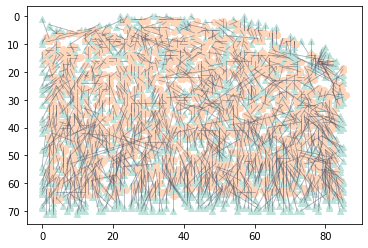

In [42]:
cel.RelocationPlot(cords30, Section1test30.obs[["x","y"]])

In [16]:
cords30 = cel.Predict_cord(Section1test30, path = "output/Mouse2D", filename = "HighReso_30")

In [18]:
cords30

array([[0.02995859, 0.26780015],
       [0.02821443, 0.27323419],
       [0.02282032, 0.34502965],
       ...,
       [0.87188512, 0.01870868],
       [0.90942508, 0.03927936],
       [0.88009536, 0.13037427]])

In [13]:
def evaluate (data_test, location_data, data_train, path, filename):
    """
    Report the results of the proposed methods in comparison to the other method
    :folder: string: specified the folder that keep the proposed DNN method
    :name: string: specified the name of the DNN method, also will be used to name the output files
    :dataSection2: AnnData: the data of Section 2
    :traindata: AnnData: the data used in training data. This is only needed for compute SSIM
    :outname: string: specified the name of the output, default is the same as the name
    """
    filename2 = "{folder}/{name}.obj".format(folder = path, name = filename)
    filehandler = open(filename2, 'rb') 
    DNNmodel = pickle.load(filehandler)
    #
    vdatax = np.expand_dims(data_test.X, axis = 0)
    vdata_rs = np.swapaxes(vdatax, 1, 2)
    DataVal = cel.wrap_gene_location(vdata_rs, location_data)
    Val_loader= torch.utils.data.DataLoader(DataVal, batch_size=1, num_workers = 0)
    #
    total_loss_org = []
    coords_predict = np.zeros((data_test.obs.shape[0],4))
    for i, img in enumerate(Val_loader):
        recon = DNNmodel(img)
        coords_predict[i,0:2] = recon[0].detach().numpy()
        coords_predict[i,2:4] = img[1]
        loss = DNNmodel.loss_function(*recon)
        total_loss_org.append(loss.get("loss").data)
    #
    np.savetxt("output/CeLEry/2022Nov/location_{holdoff}_predict.csv".format(holdoff = filename), coords_predict)
    #
    SSIM_result =  cel.get_SSIM(coords_predict, referadata = data_test, trainAnn = data_train, referlocation = data_test.obs[["x","y"]], genelist = range(data_test.X.shape[1]))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][0,:,:,0]), filename = "output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM_1".format(holdoff = filename))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][0,:,:]), filename = "output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM_anchor_1".format(holdoff = filename))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][1,:,:,0]), filename = "output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM_2".format(holdoff = filename))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][1,:,:]), filename = "output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM_anchor_2".format(holdoff = filename))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][2,:,:,0]), filename = "output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM_3".format(holdoff = filename))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][2,:,:]), filename = "output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM_anchor_3".format(holdoff = filename))
    np.save("output/CeLEry/2022Nov/CeLEry_{holdoff}_SSIM.npy".format(holdoff = filename), np.array(SSIM_result[0]))
    np.save("output/CeLEry/2022Nov/CeLEry_{holdoff}_cor.npy".format(holdoff = filename), np.array(SSIM_result[3]))
    np.save("output/CeLEry/2022Nov/CeLEry_{holdoff}_MSE.npy".format(holdoff = filename), np.array(SSIM_result[4]))
    del SSIM_result
    #
    losstotal_itemize = [x.item() for x in total_loss_org]
    losstotal = sum(losstotal_itemize)
    print('Loss for enhancement data only:{:.4f}'.format(float(losstotal)))

100%|██████████| 358/358 [00:04<00:00, 74.13it/s]


Loss for enhancement data only:0.3929


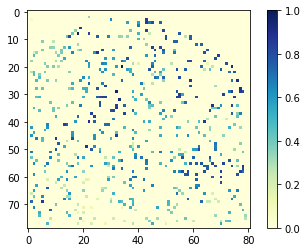

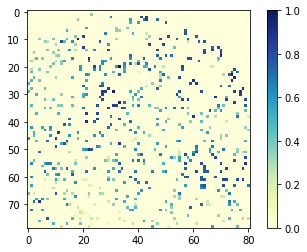

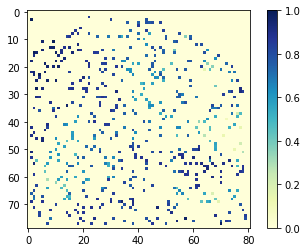

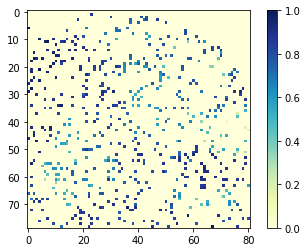

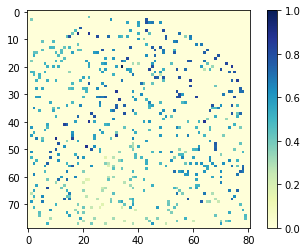

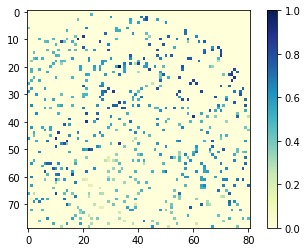

In [14]:
evaluate(Section1test10, location_data =Section1test10.obs[["x","y"]], data_train = Section1train10,  path = "output/CeLEry/2022Nov", filename = "HighReso_10")

100%|██████████| 358/358 [00:14<00:00, 25.48it/s]


Loss for enhancement data only:1.4073


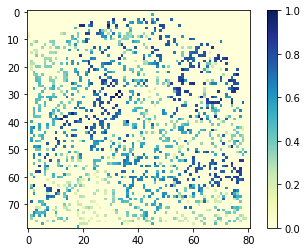

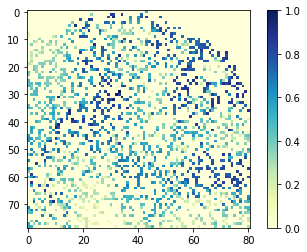

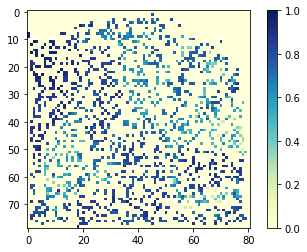

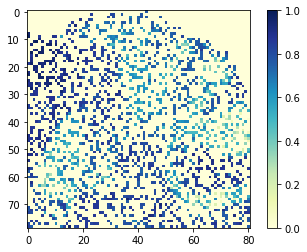

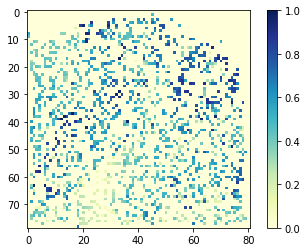

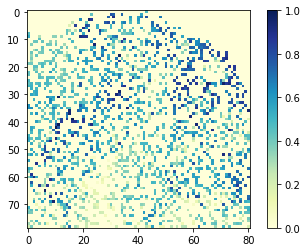

In [15]:
evaluate(Section1test30, location_data =Section1test30.obs[["x","y"]], data_train = Section1train30,  path = "output/CeLEry/2022Nov", filename = "HighReso_30")

100%|██████████| 358/358 [00:23<00:00, 15.39it/s]


Loss for enhancement data only:2.5506


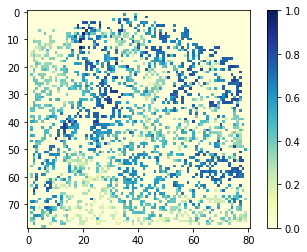

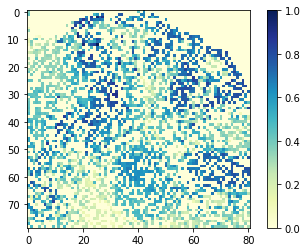

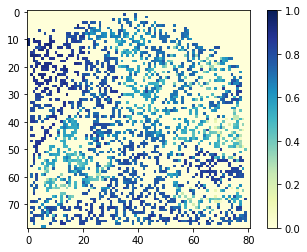

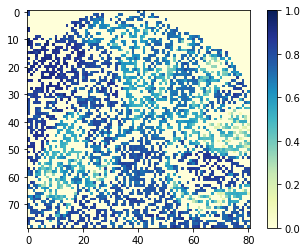

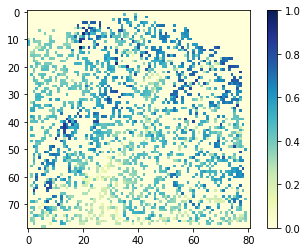

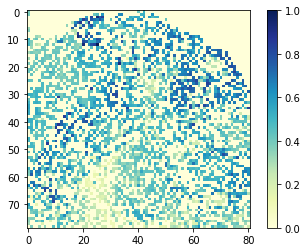

In [16]:
evaluate(Section1test50, location_data =Section1test50.obs[["x","y"]], data_train = Section1train50,  path = "output/CeLEry/2022Nov", filename = "HighReso_50")

In [27]:
Section1test10

View of AnnData object with n_obs × n_vars = 582 × 358
    obs: 'x', 'y'
    var: 'genename'